# Anomaly Detection Pipeline – Converted from main.py

In [1]:
import os
import pandas as pd
from config import DEVICES_DATA_PATH, SAVED_MODELS_PATH, global_start_time, process, start_memory
from device_utils import get_device_files, get_model_name, get_numerical_features
from state_anomaly import detect_state_anomalies
# Removed imports for RF classifier (apply_random_forest, train_rf_for_device) as they belong to IC or are no longer used here
from plotting import plot_reconstruction_error # Only import the AD plot
from export_json import export_incident_json # Keep this to generate anomalies_output.json
import postgres_connection as pg_conn

2025-06-25 05:48:25.000065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 05:48:25.000759: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 05:48:25.004860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 05:48:25.013116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750830505.026405   28725 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750830505.03

In [2]:
# Define the process_device function using csv
def process_device(device_type : str, csv_file_path : str): # Changed parameter name to csv_file_path for clarity
    """
    Process a device's data and apply anomaly detection.
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame() # This will collect processed data from all states

    try:
        df = pd.read_csv(csv_file_path) # csv_file_path is already a full path
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        # Process each state using LSTM
        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            # Concatenate processed state data, only if it has reconstruction_error
            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed], ignore_index=True)
            else:
                print(f"⚠️ {device_type} - State {state} processed, but 'reconstruction_error' column is missing. Skipping concatenation.")


        if df_all.empty:
            print(f"⚠️ {device_type} - No data processed for any state. Skipping further steps.")
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        # Removed RF classifier application (as it's part of IC or removed)
        # df_all = apply_random_forest(df_all, device_type)

        # --- DEBUG: is_anomaly counts BEFORE JSON export ---
        print(f"\n--- DEBUG: {device_type} is_anomaly counts BEFORE JSON export ---")
        if 'is_anomaly' in df_all.columns:
            print(df_all['is_anomaly'].value_counts())
        else:
            print("'is_anomaly' column not found in df_all!")
        print("--------------------------------------------------")

        # ✅ Only plot reconstruction error
        # This function should be in the plotting.py of the AD repo
        plot_reconstruction_error(df_all, device_type, "All States")

        # ✅ Export JSON output for downstream systems
        # This will now export all processed data points (with error and is_anomaly)
        export_incident_json(df_all, device_type)


        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        import traceback # Import traceback here for debugging
        traceback.print_exc() # Print full traceback for debugging
        return None
    
# Define the process_device function using query result 

def process_device_query(device_type: str, df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Process a device's time-series DataFrame and apply anomaly detection.

    Parameters:
    - device_type: device name (used for model naming, plots, etc.)
    - df_raw: time-series DataFrame (e.g., from get_motor_timeseries)
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame()

    try:
        df = df_raw.copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed], ignore_index=True)
            else:
                print(f"⚠️ {device_type} - State {state} processed, but 'reconstruction_error' column is missing.")

        if df_all.empty:
            print(f"⚠️ {device_type} - No data processed for any state.")
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        print(f"\n--- DEBUG: {device_type} is_anomaly counts BEFORE JSON export ---")
        if 'is_anomaly' in df_all.columns:
            print(df_all['is_anomaly'].value_counts())
        else:
            print("'is_anomaly' column not found in df_all!")

        plot_reconstruction_error(df_all, device_type, "All States")
        export_incident_json(df_all, device_type)

        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
2025-06-25 05:48:28.087328: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316732 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    294
True       2
Name: count, dtype: int64


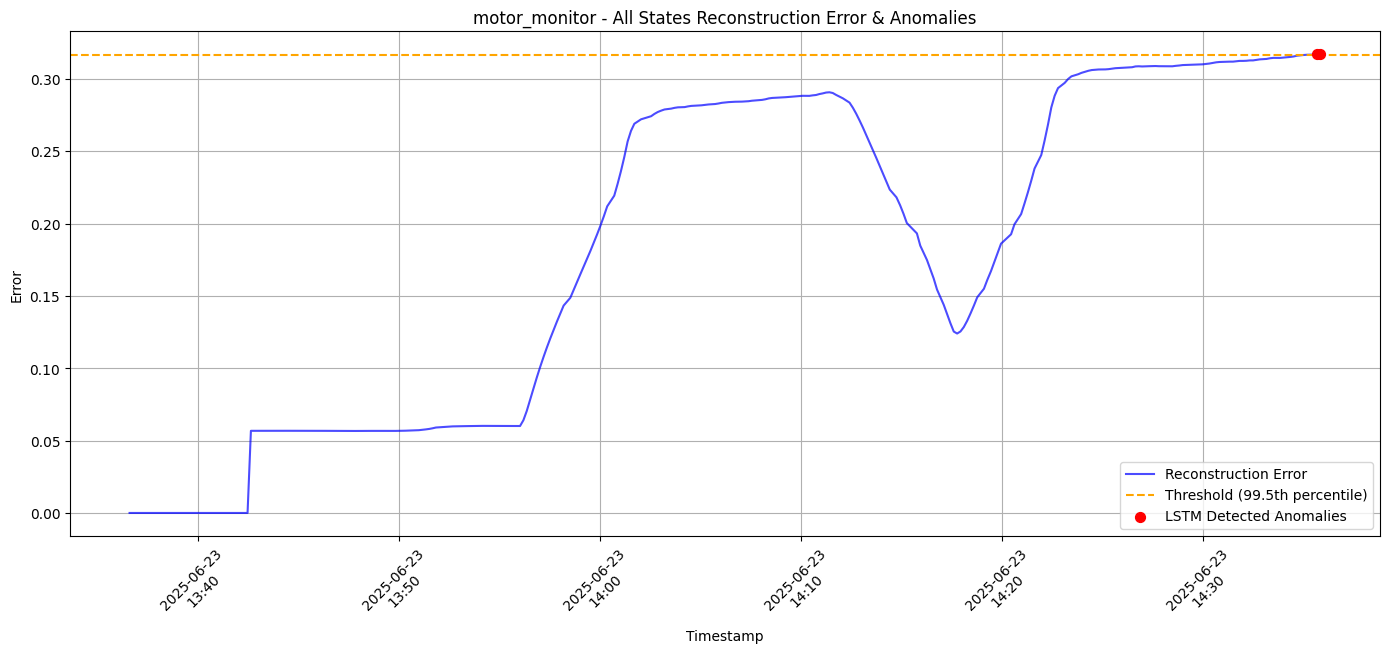

📤 Exported 296 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.37 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314404 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    228
True       1
Name: count, dtype: int64


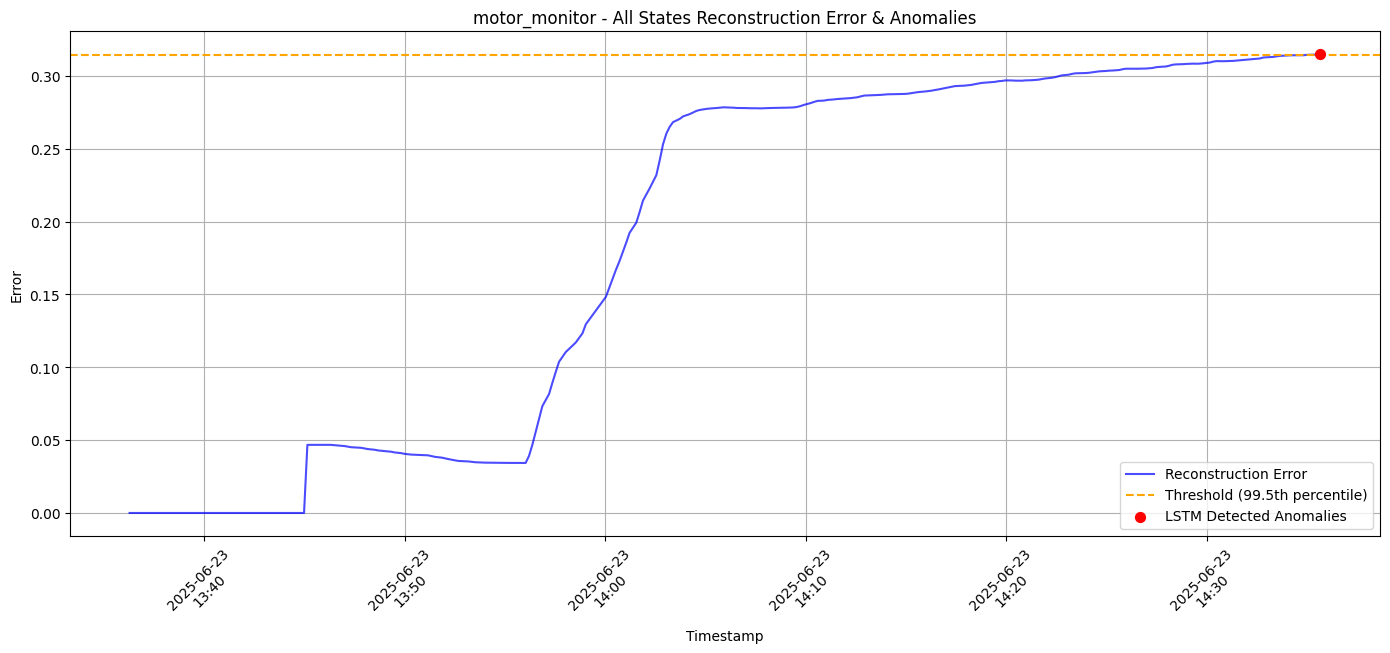

📤 Exported 229 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.32 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314740 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    293
True       2
Name: count, dtype: int64


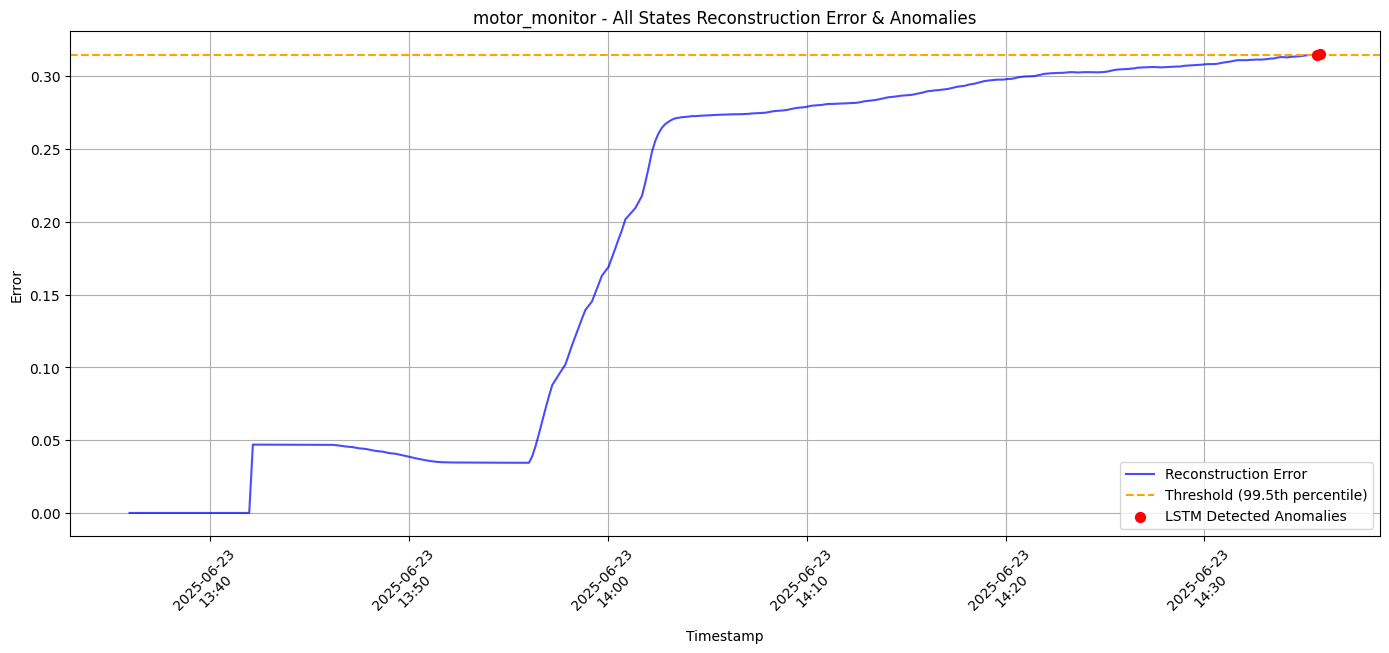

📤 Exported 295 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.42 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.317533 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    291
True       2
Name: count, dtype: int64


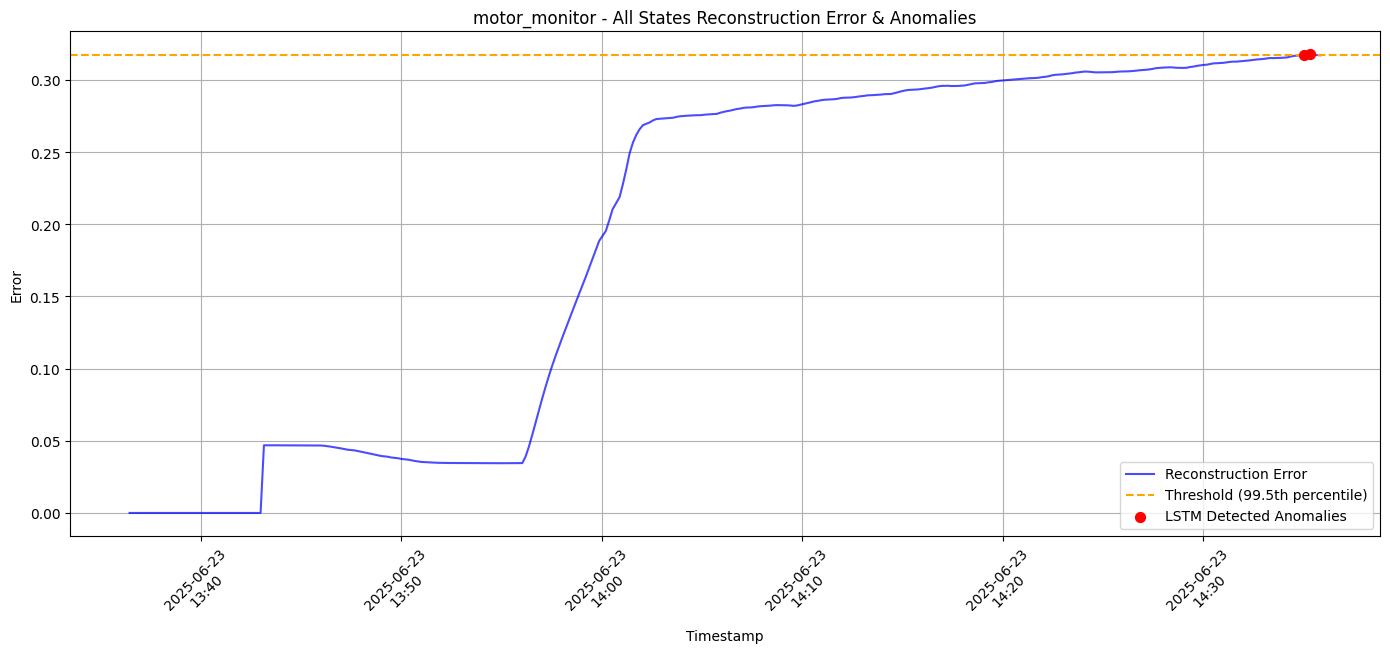

📤 Exported 293 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.22 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.318109 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    280
True       2
Name: count, dtype: int64


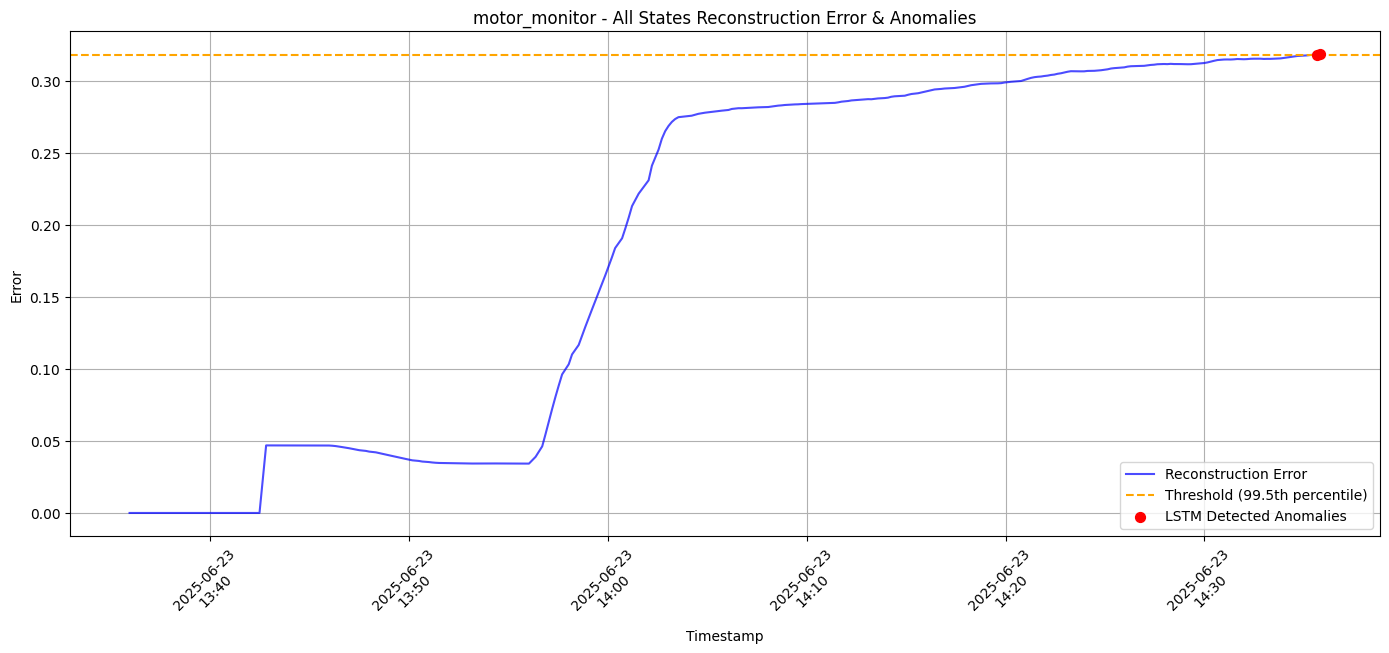

📤 Exported 282 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.48 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.305948 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    289
True       2
Name: count, dtype: int64


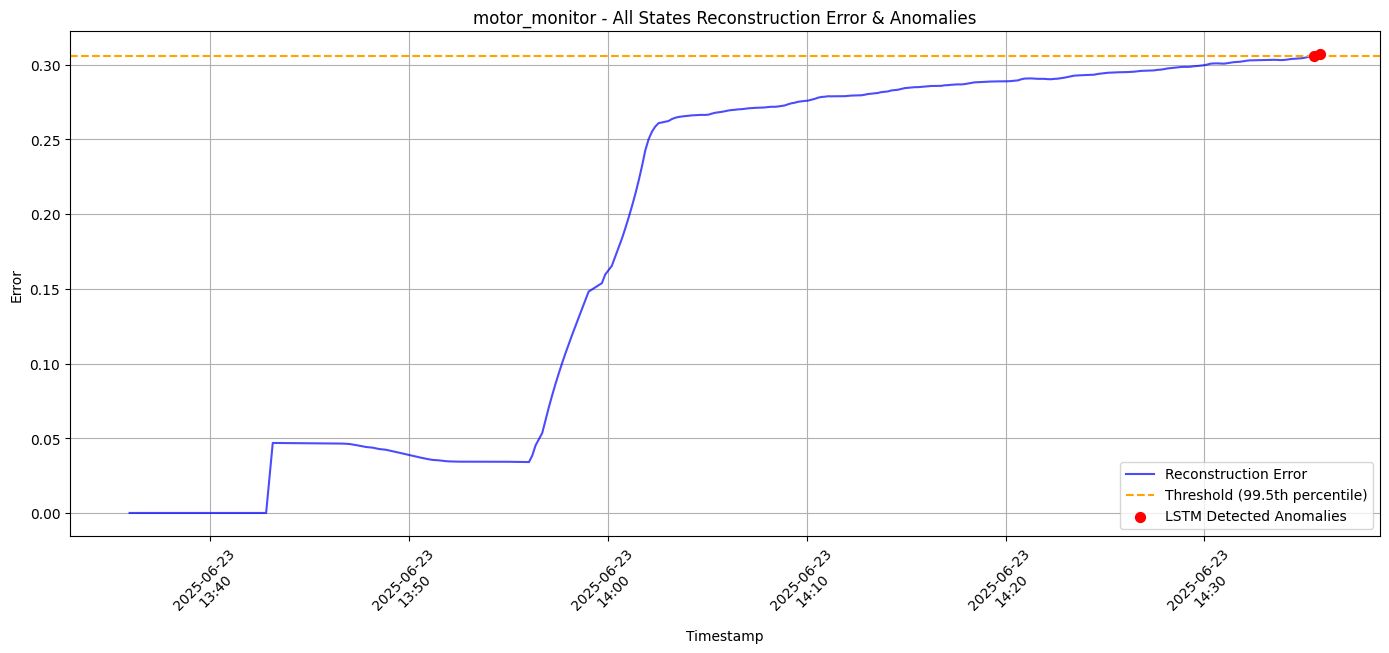

📤 Exported 291 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.44 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314029 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    285
True       2
Name: count, dtype: int64


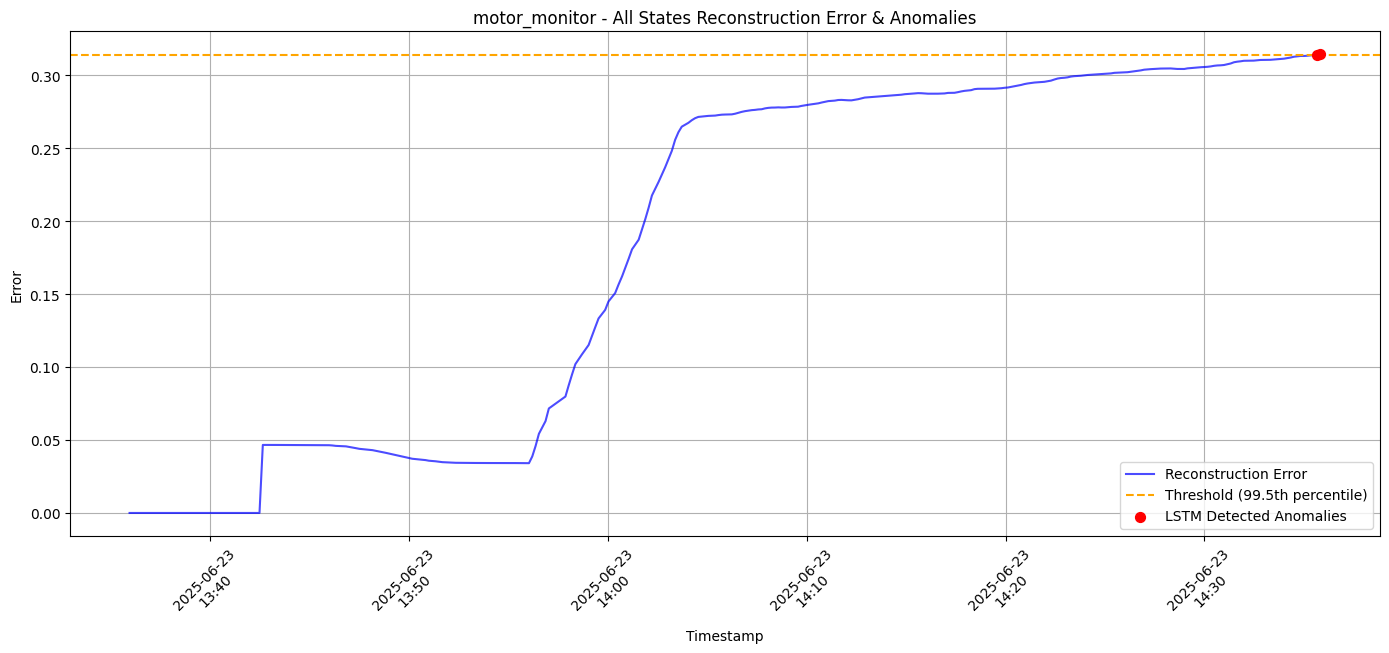

📤 Exported 287 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.26 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310073 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    258
True       2
Name: count, dtype: int64


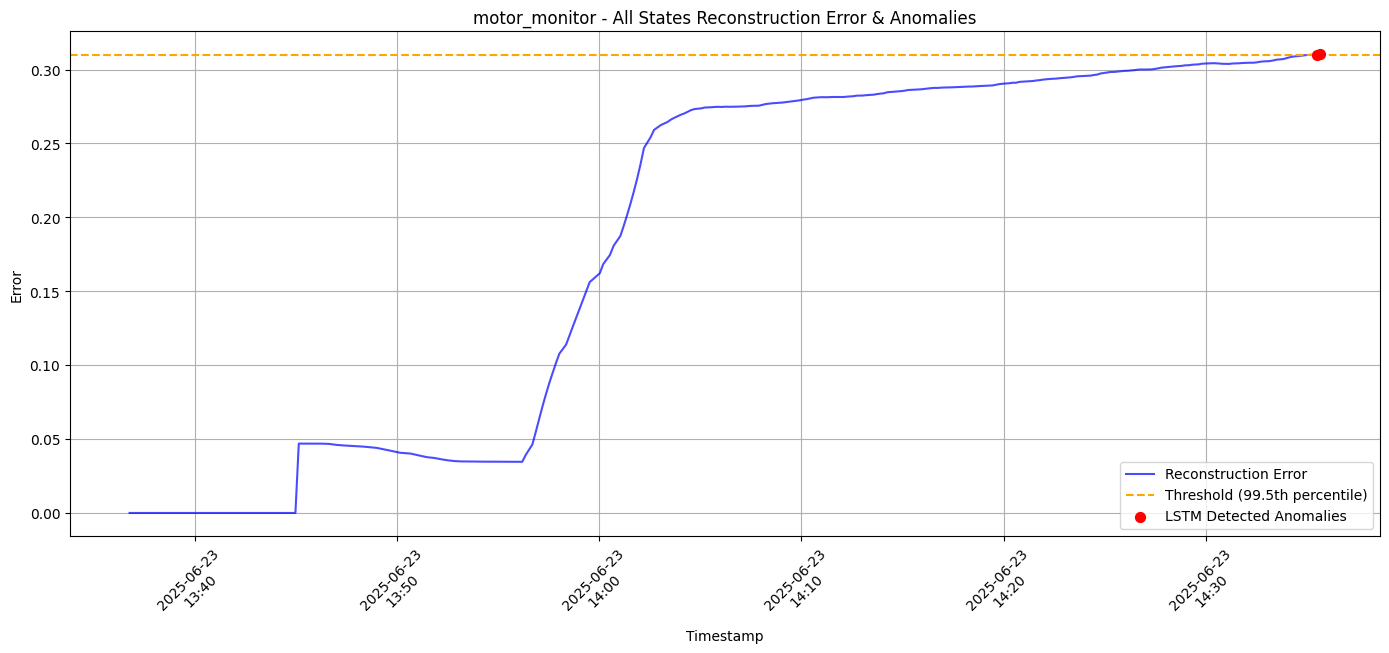

📤 Exported 260 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.48 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313500 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    220
True       1
Name: count, dtype: int64


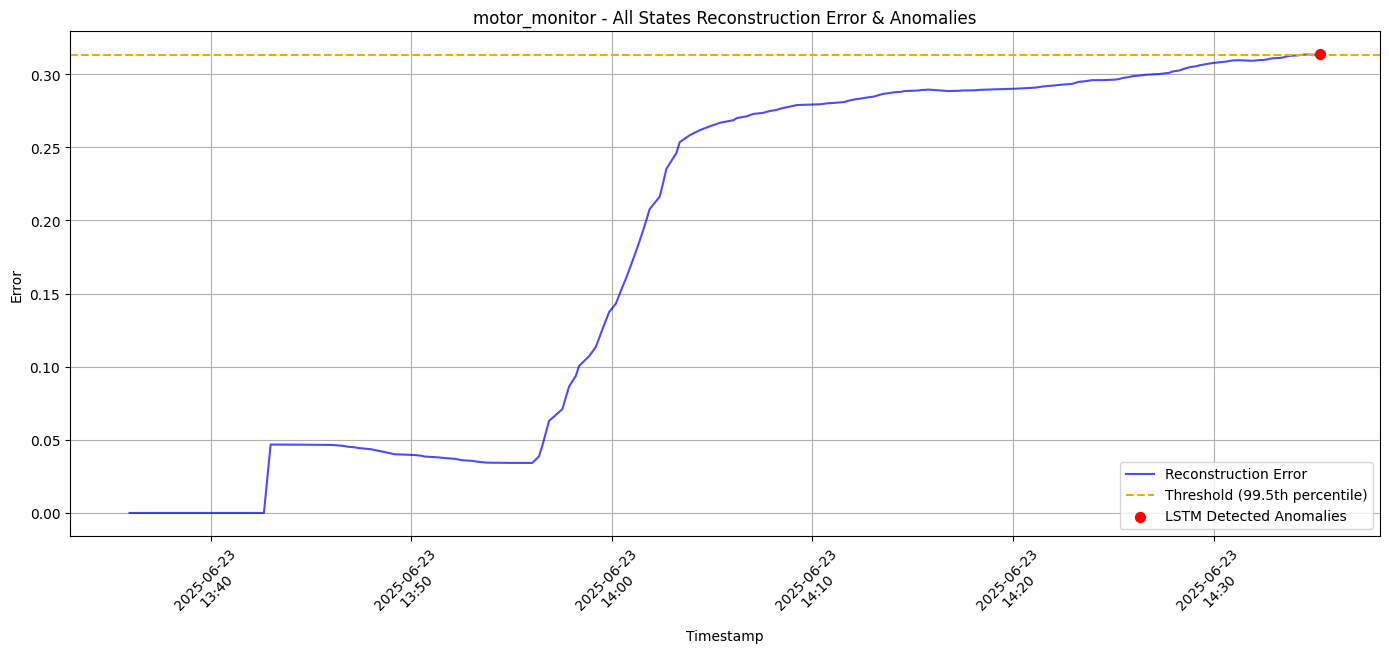

📤 Exported 221 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.42 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312421 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    234
True       2
Name: count, dtype: int64


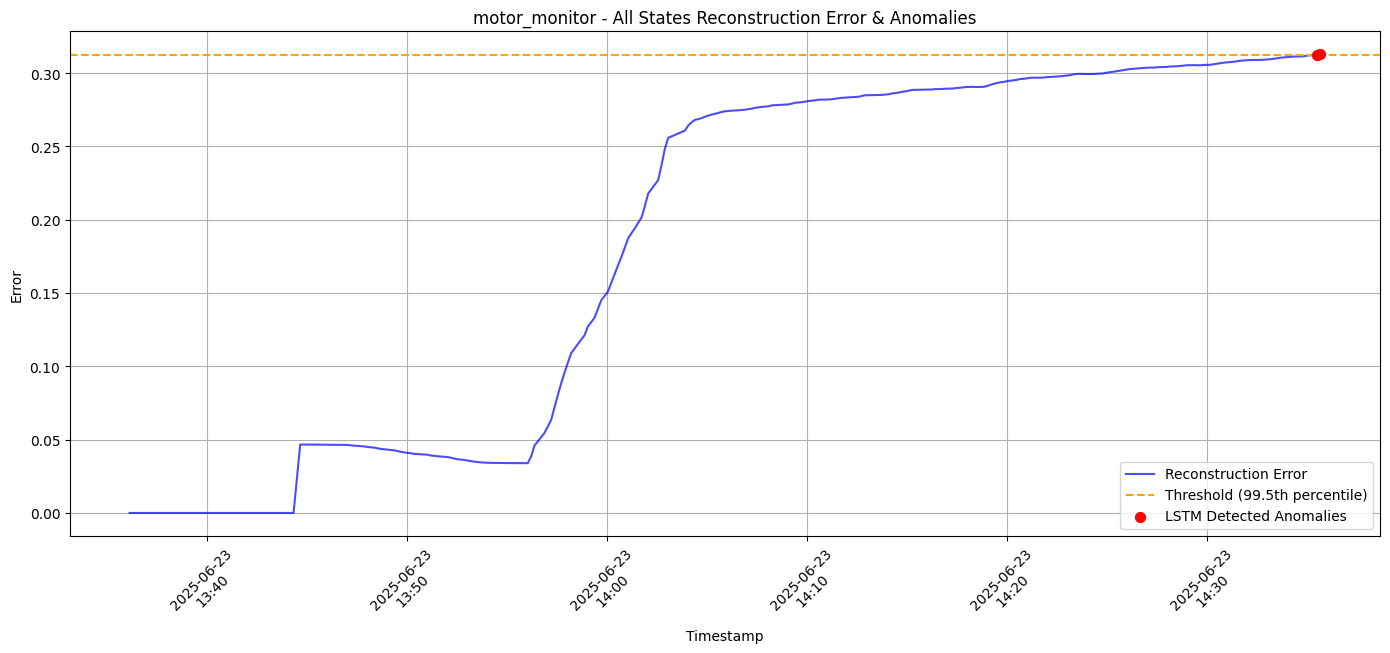

📤 Exported 236 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.19 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.311508 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    207
True       1
Name: count, dtype: int64


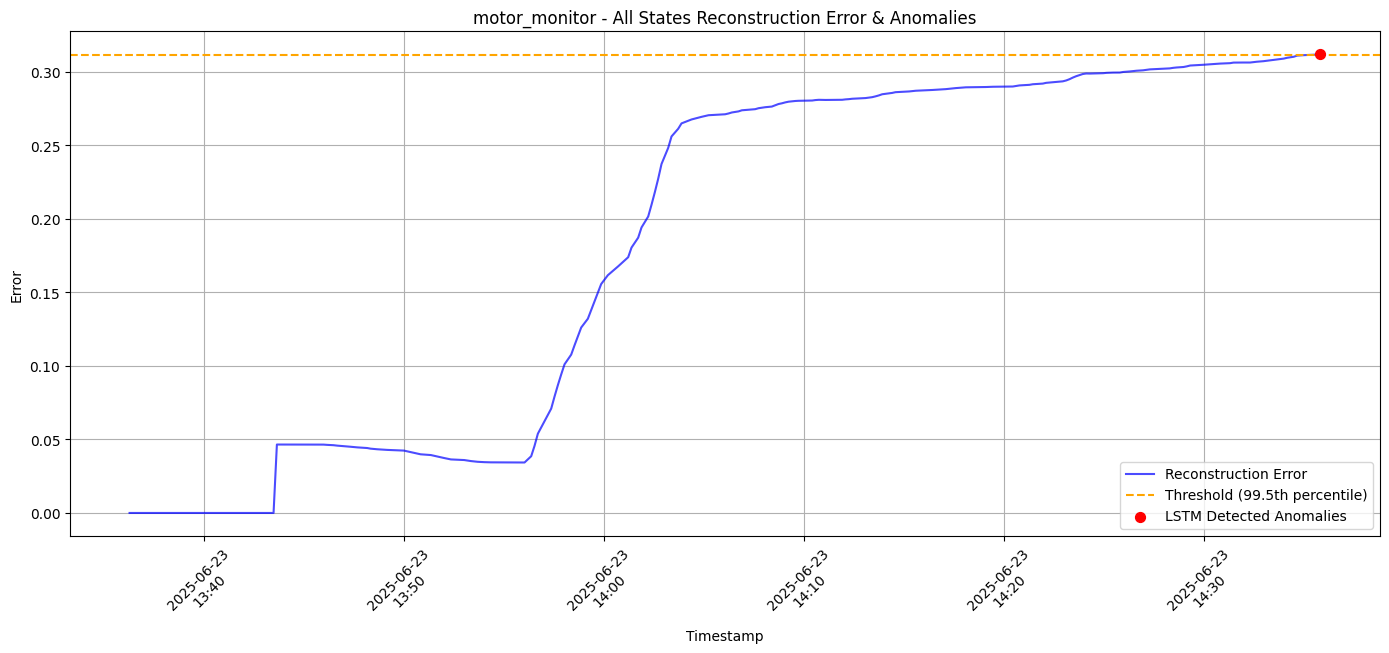

📤 Exported 208 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.42 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.317419 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    202
True       1
Name: count, dtype: int64


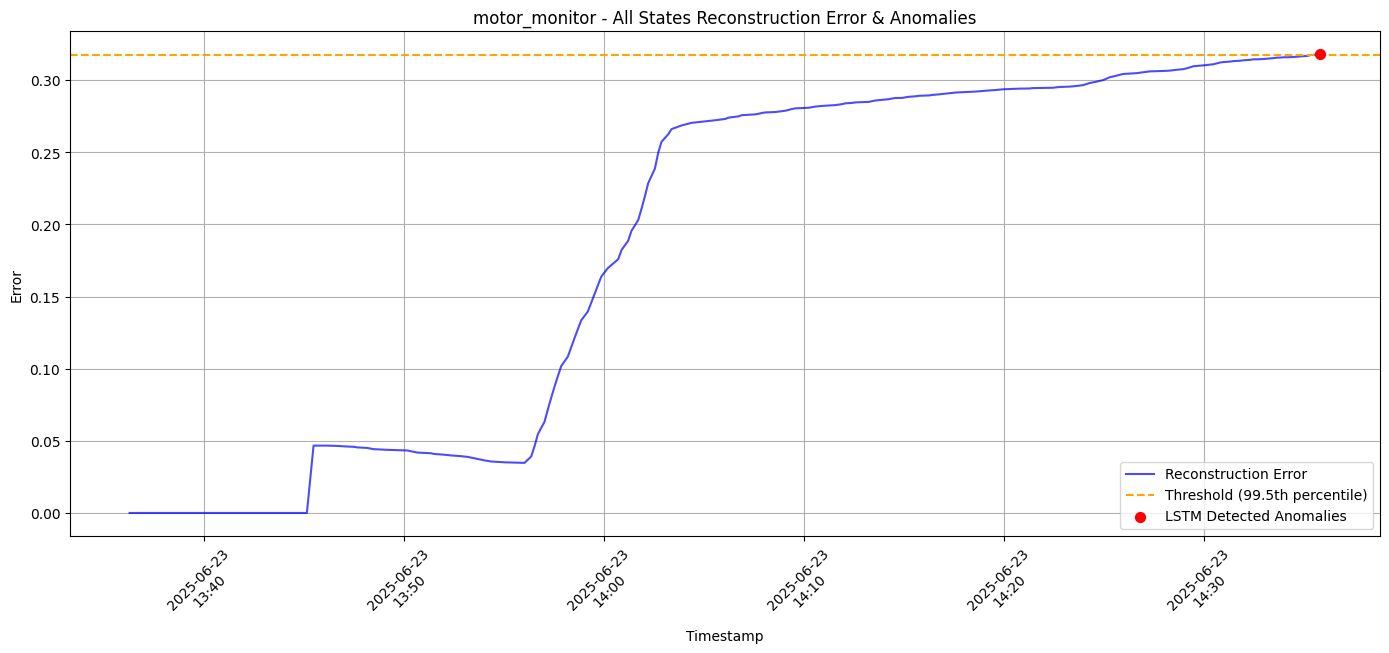

📤 Exported 203 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.14 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.317121 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    223
True       1
Name: count, dtype: int64


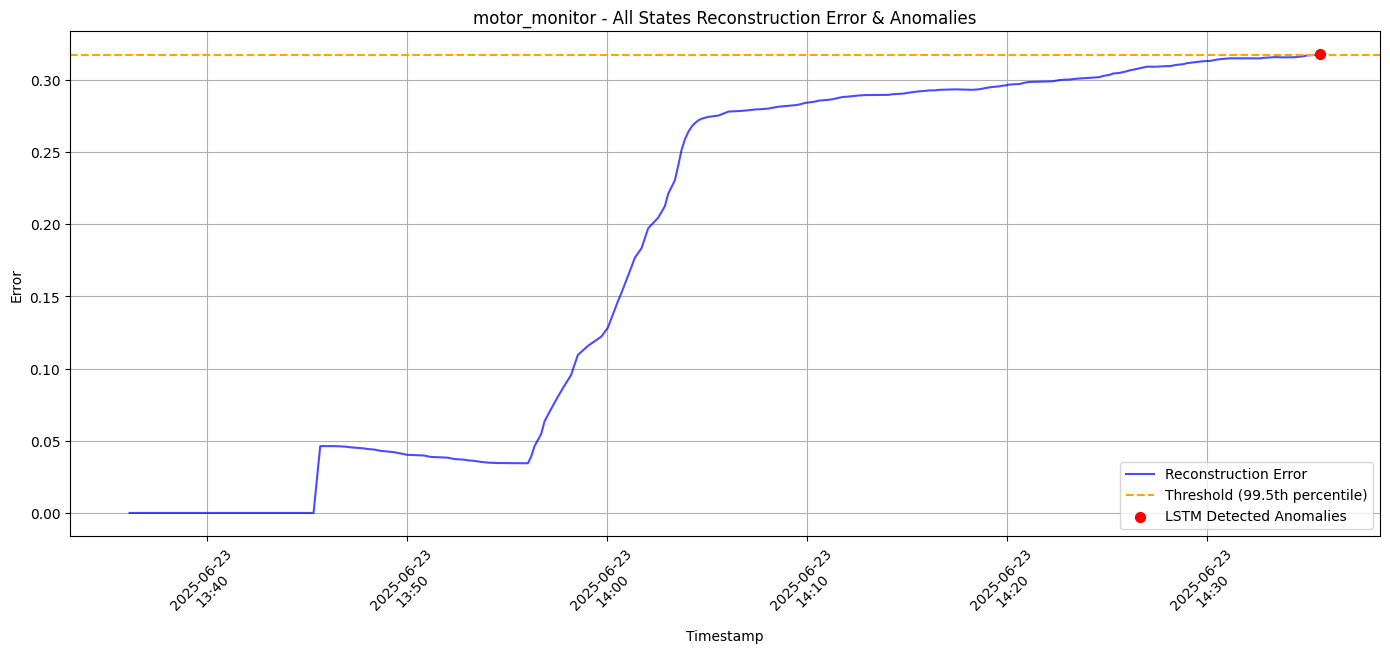

📤 Exported 224 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.40 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.318611 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    213
True       1
Name: count, dtype: int64


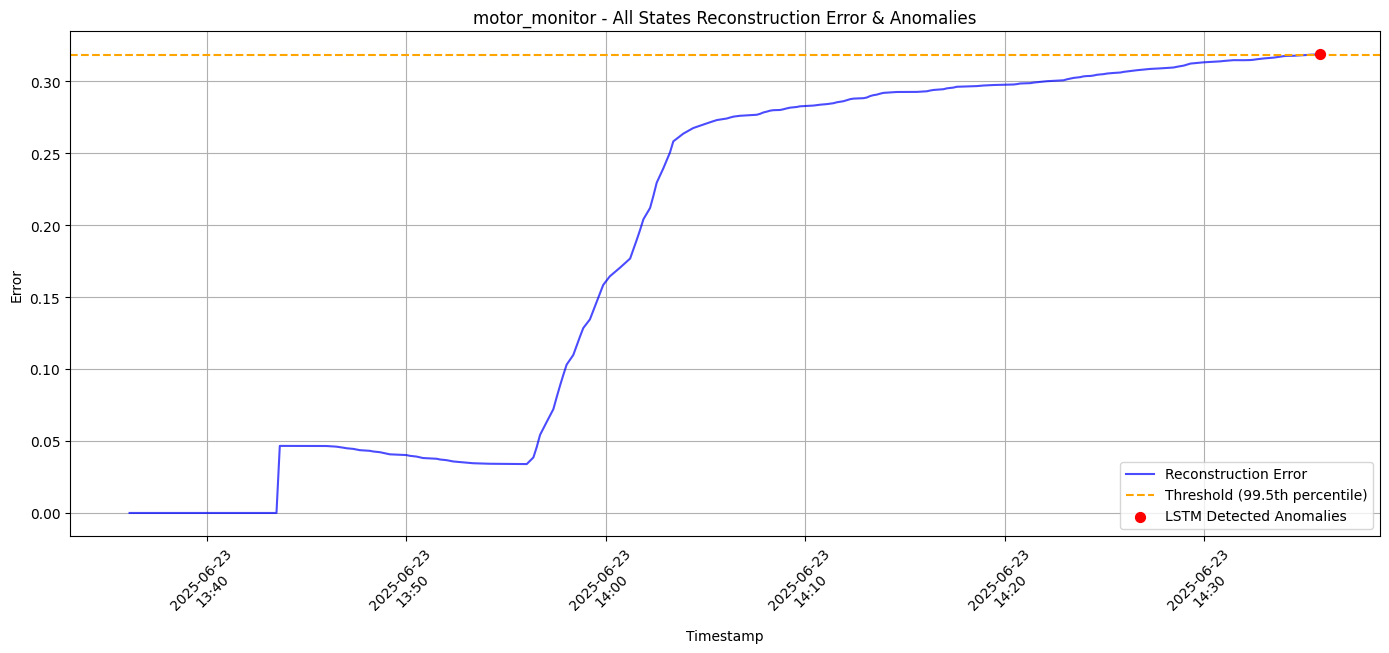

📤 Exported 214 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.16 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312598 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    231
True       2
Name: count, dtype: int64


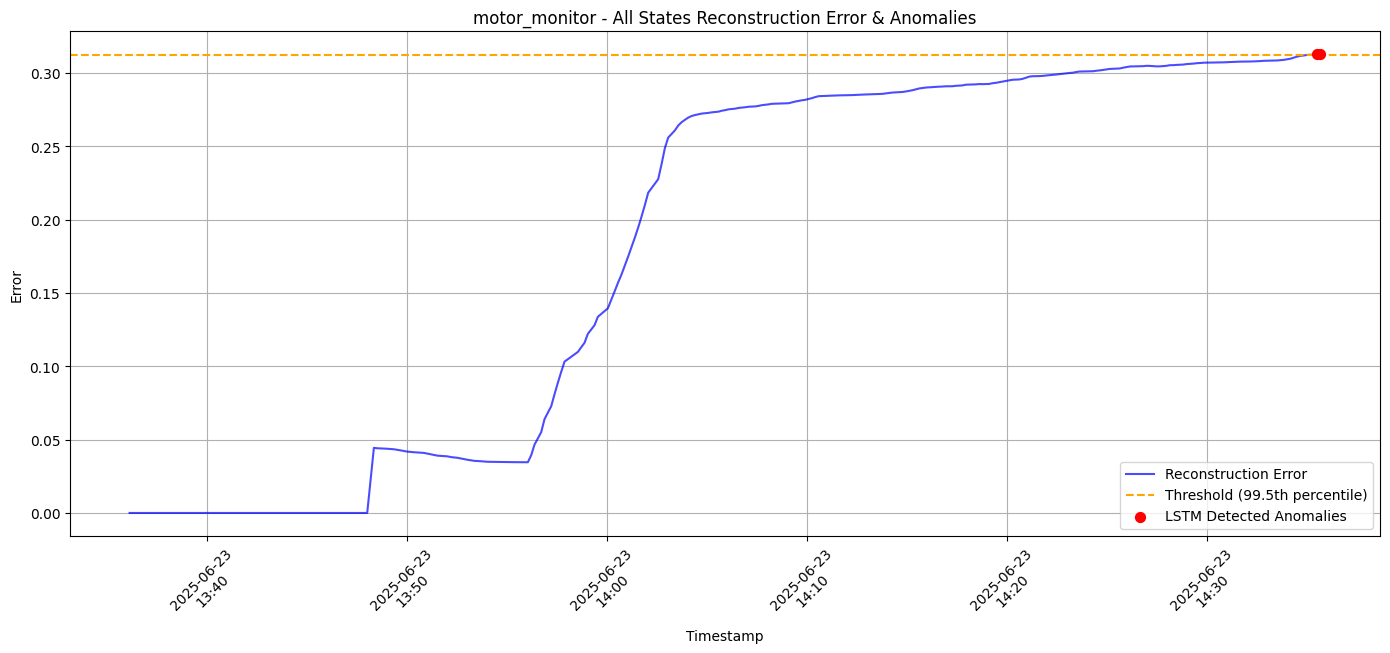

📤 Exported 233 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.34 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312971 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    224
True       1
Name: count, dtype: int64


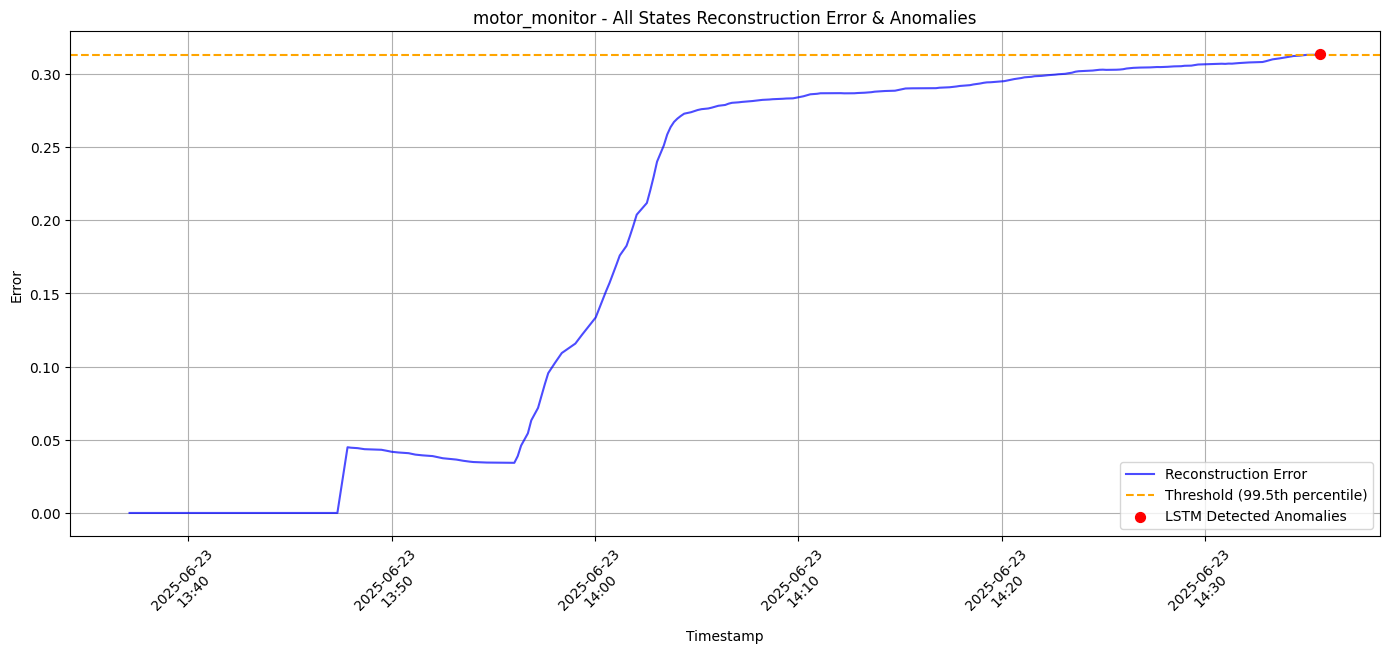

📤 Exported 225 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.42 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.315787 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    214
True       1
Name: count, dtype: int64


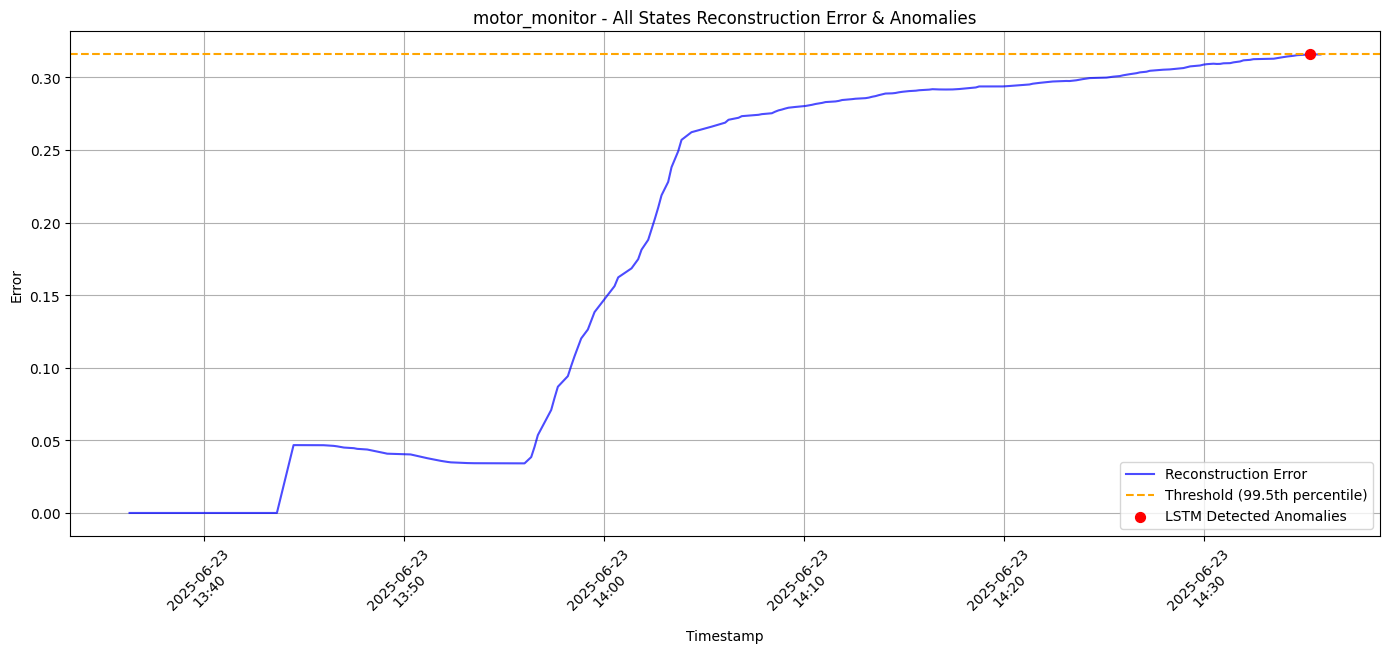

📤 Exported 215 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.16 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.315246 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    236
True       2
Name: count, dtype: int64


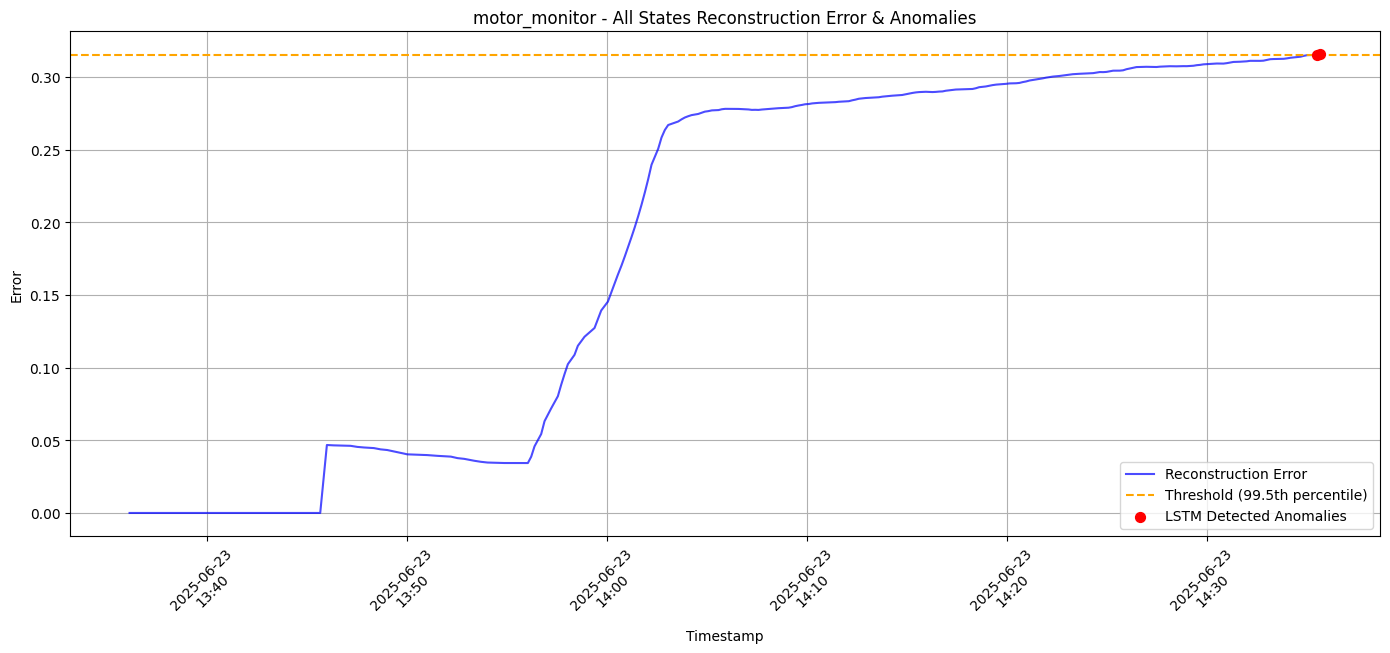

📤 Exported 238 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.41 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316209 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    203
True       1
Name: count, dtype: int64


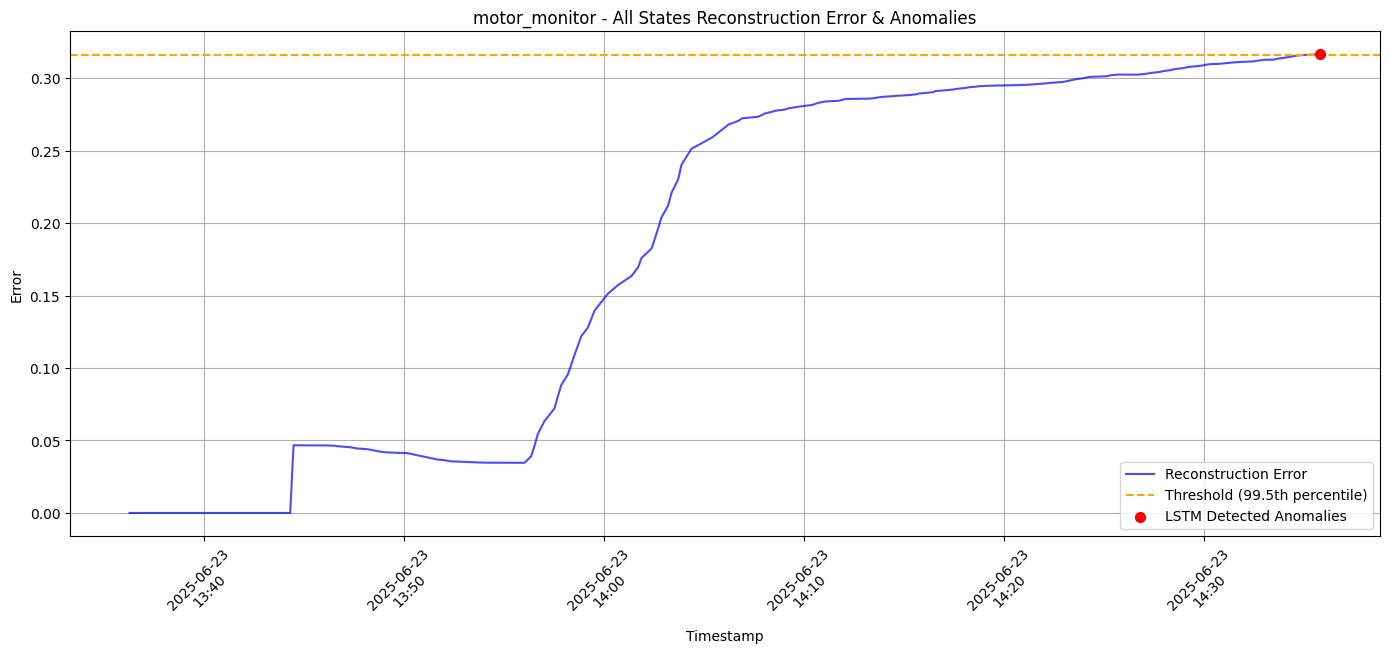

📤 Exported 204 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.40 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314014 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    231
True       2
Name: count, dtype: int64


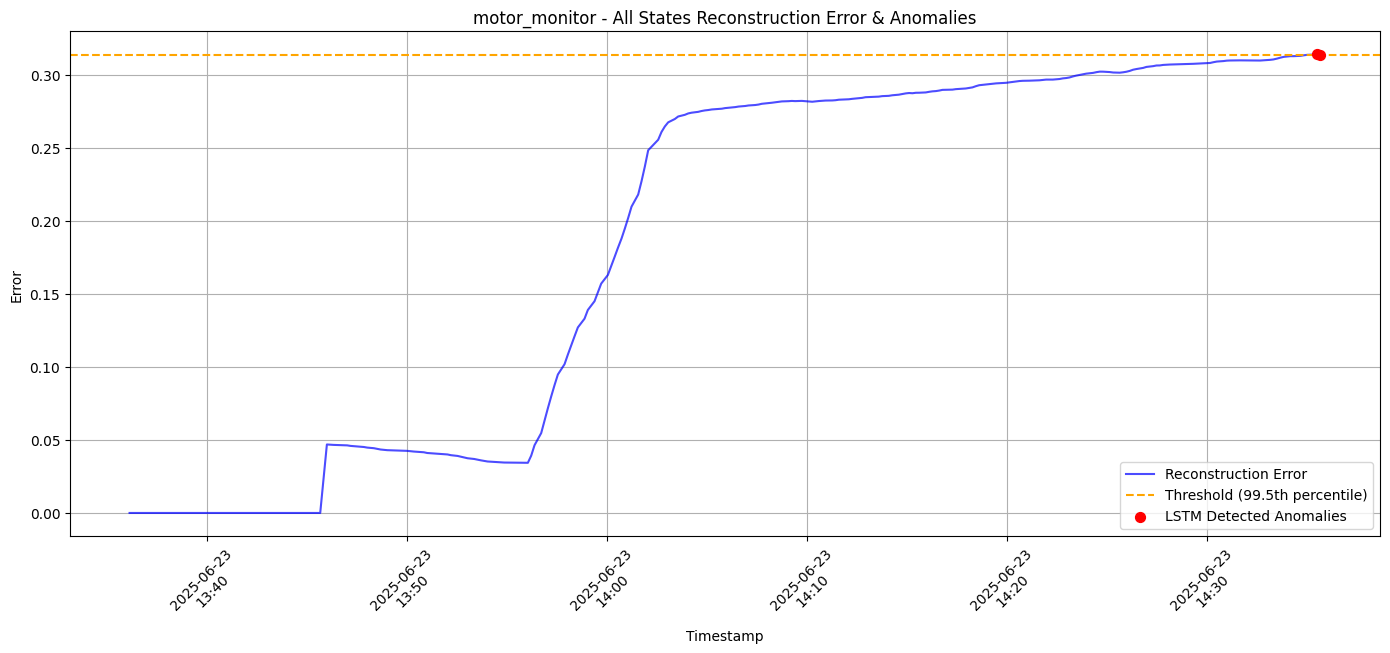

📤 Exported 233 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.19 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313278 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    201
True       1
Name: count, dtype: int64


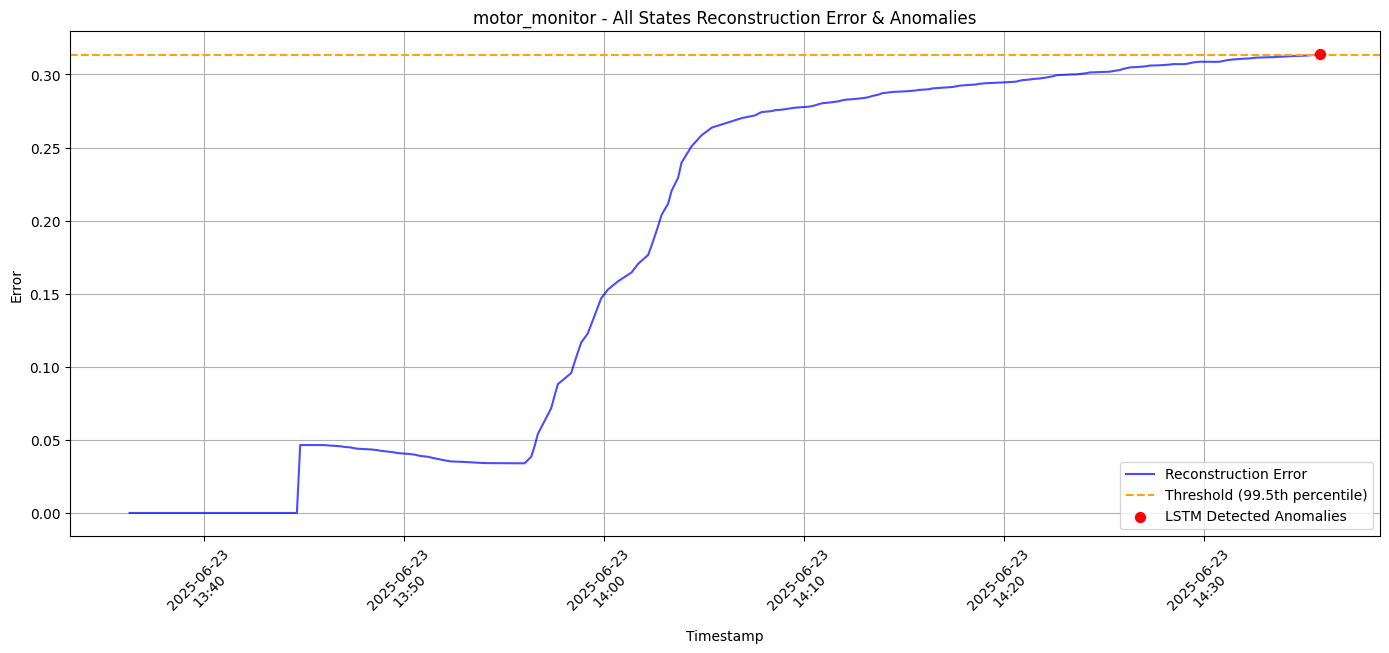

📤 Exported 202 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.60 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316463 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    223
True       1
Name: count, dtype: int64


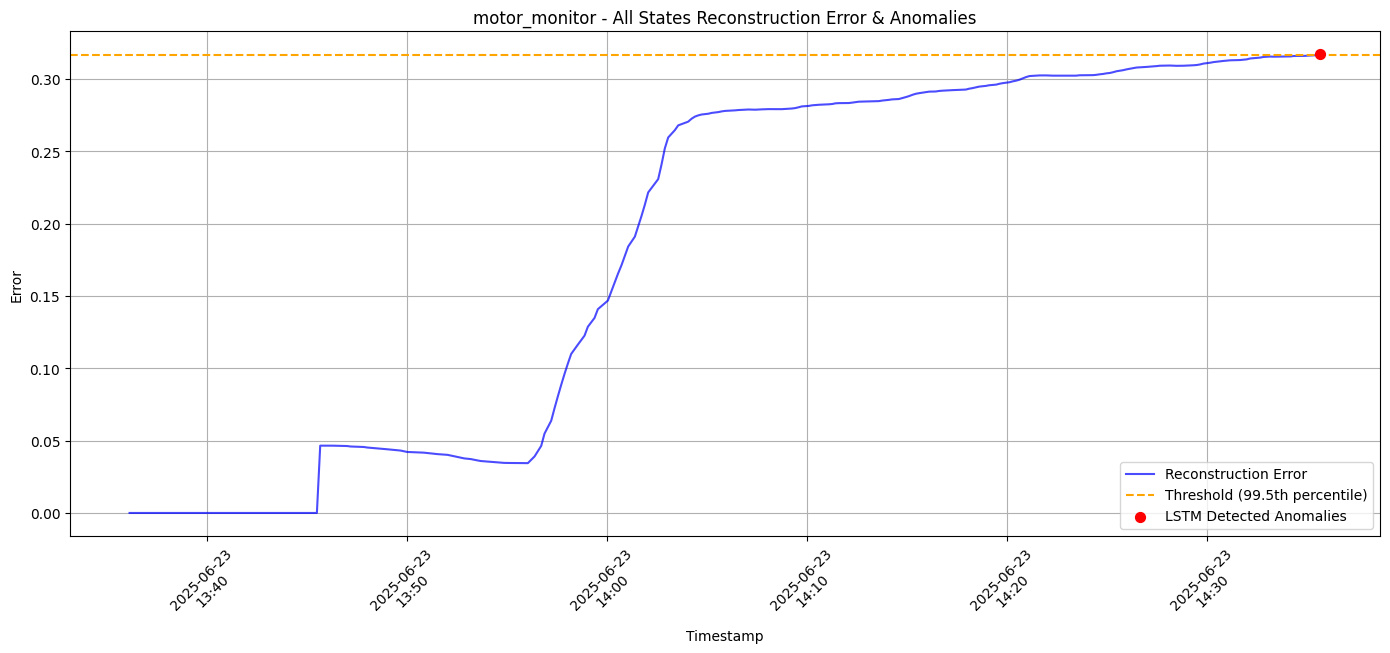

📤 Exported 224 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.29 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313818 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    250
True       2
Name: count, dtype: int64


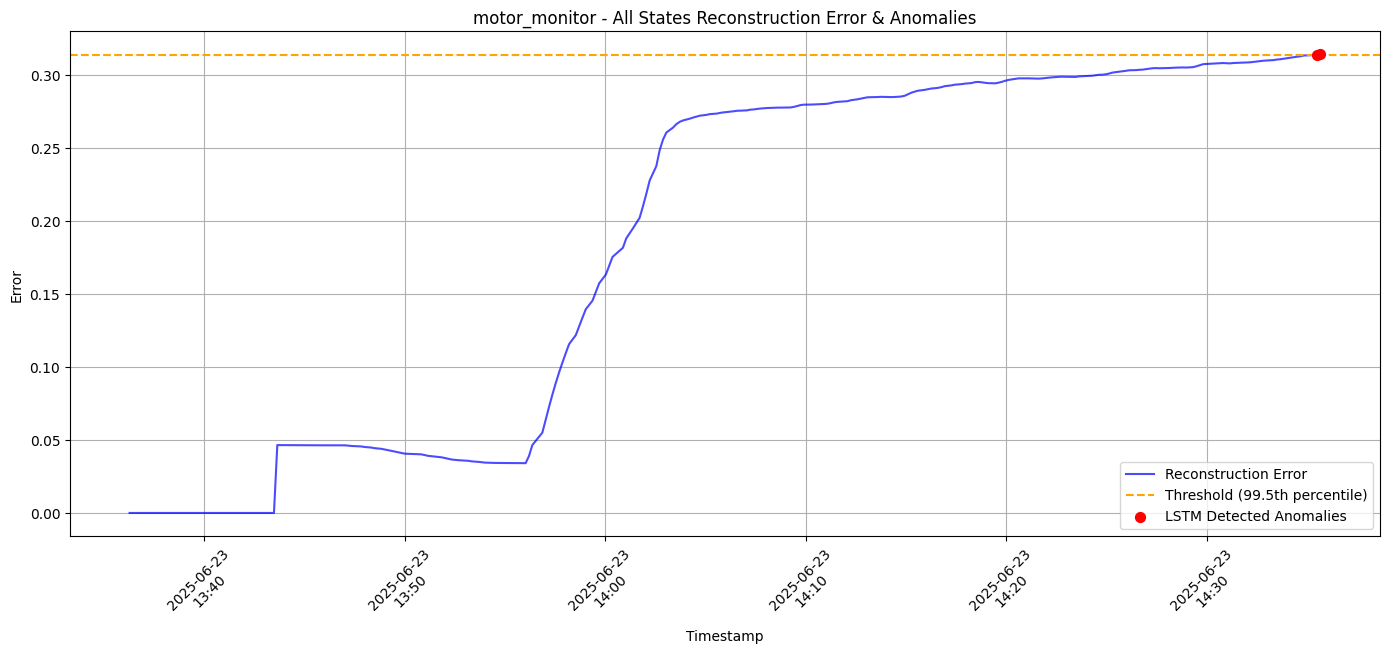

📤 Exported 252 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.48 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.308942 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    216
True       1
Name: count, dtype: int64


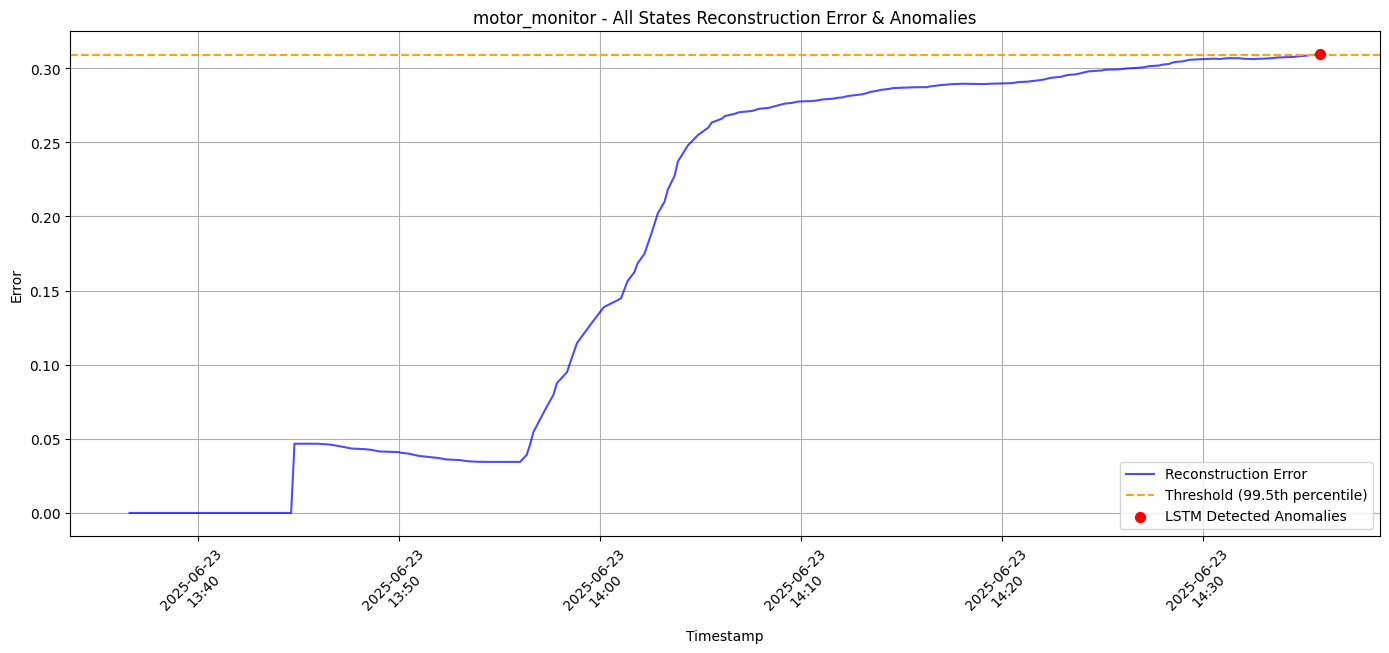

📤 Exported 217 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.69 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.307687 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    231
True       2
Name: count, dtype: int64


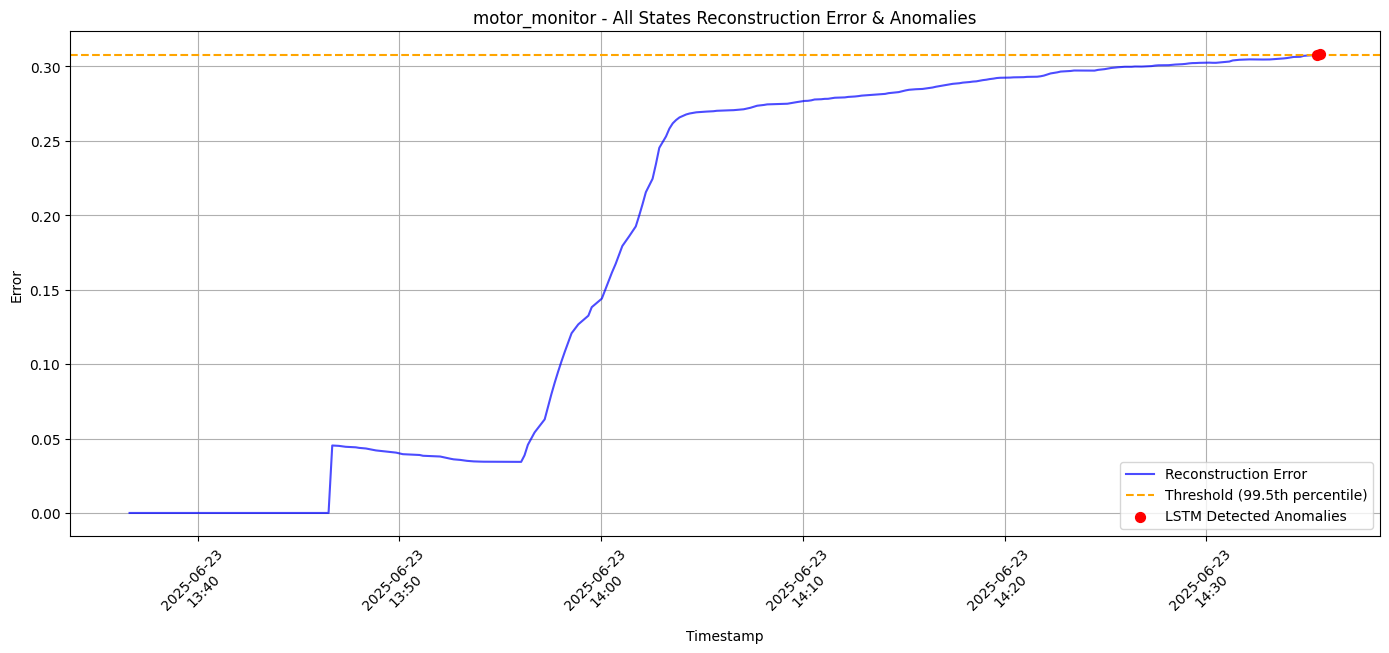

📤 Exported 233 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.16 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.309901 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    211
True       1
Name: count, dtype: int64


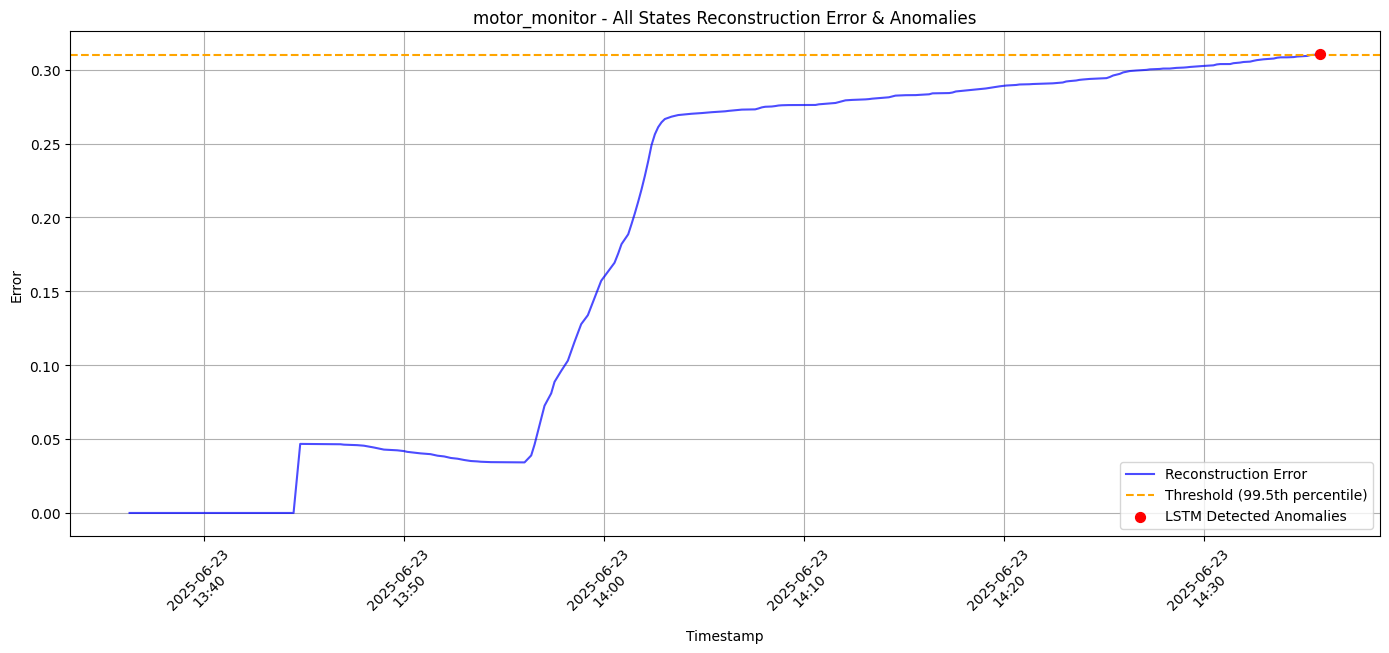

📤 Exported 212 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.51 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.322355 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    238
True       2
Name: count, dtype: int64


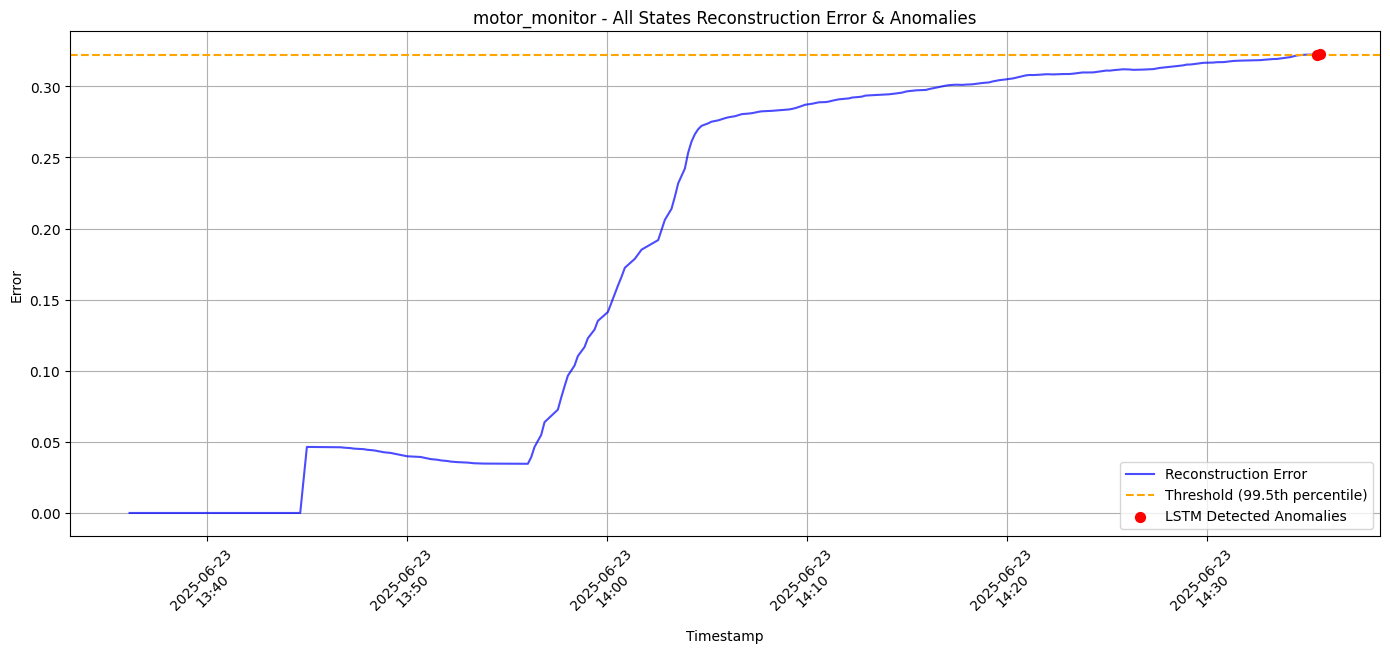

📤 Exported 240 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.16 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.311106 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    203
True       1
Name: count, dtype: int64


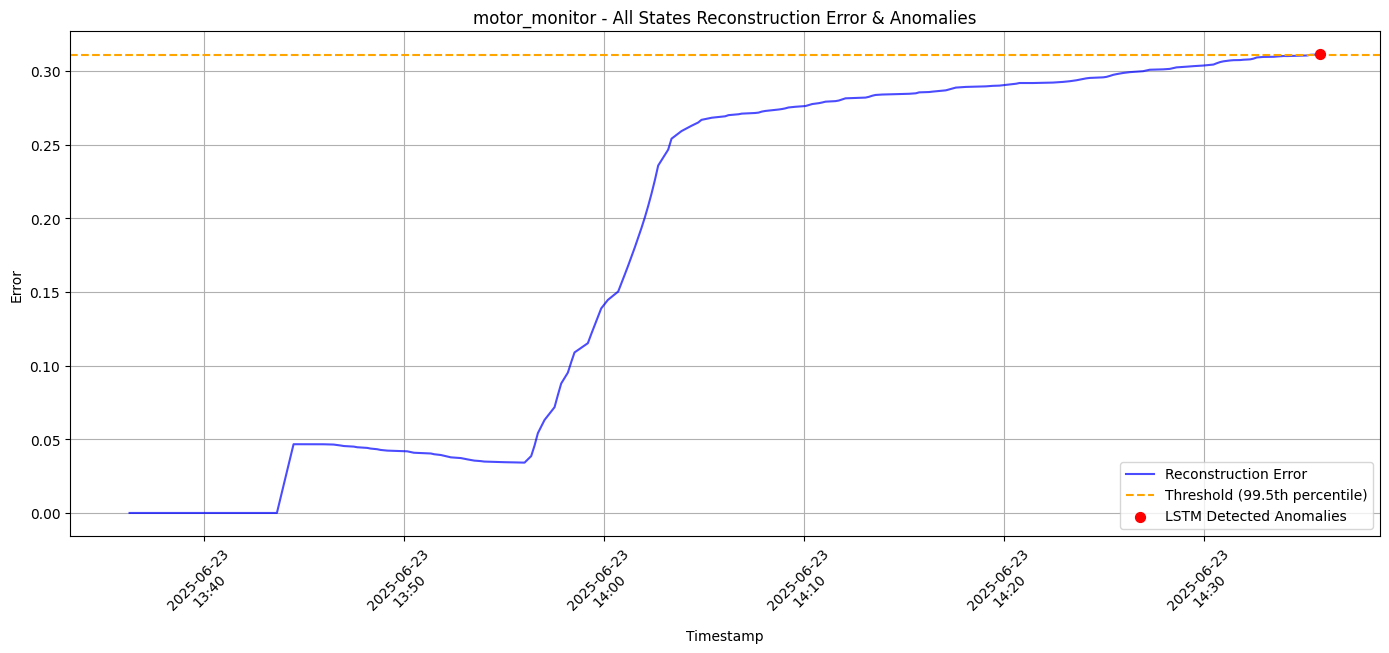

📤 Exported 204 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.50 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313925 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    231
True       2
Name: count, dtype: int64


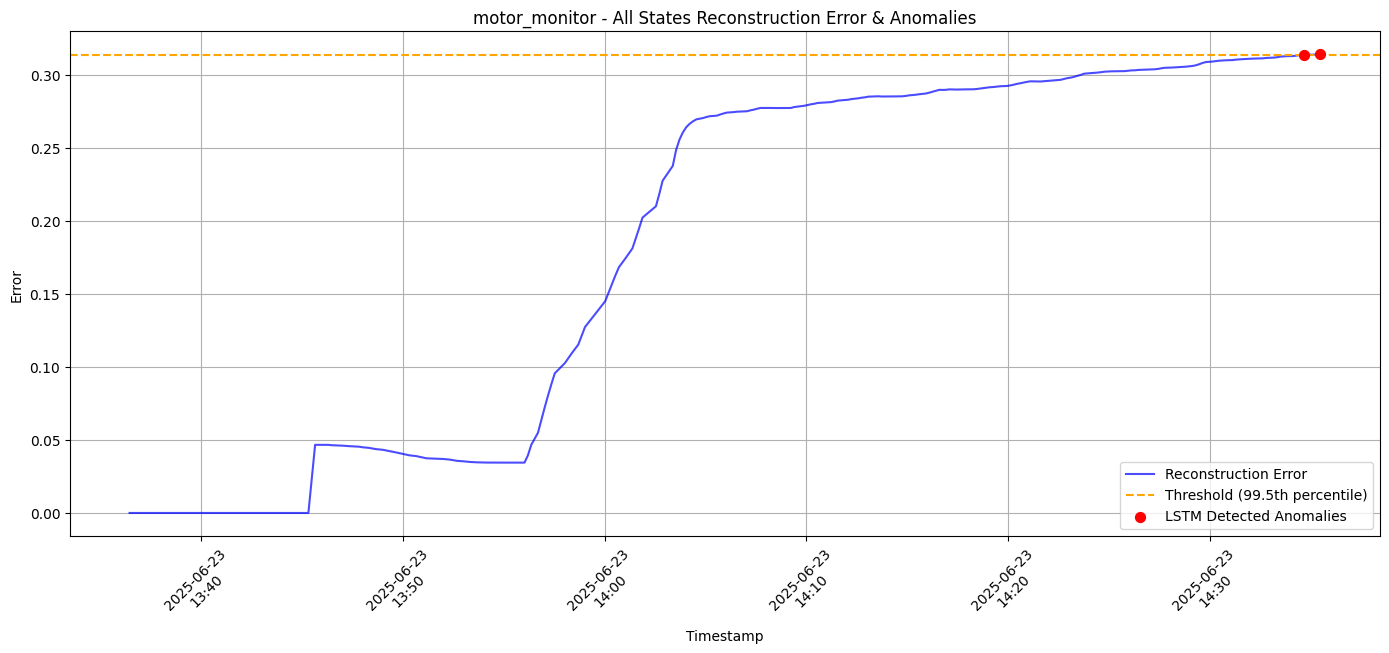

📤 Exported 233 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.55 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313818 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    250
True       2
Name: count, dtype: int64


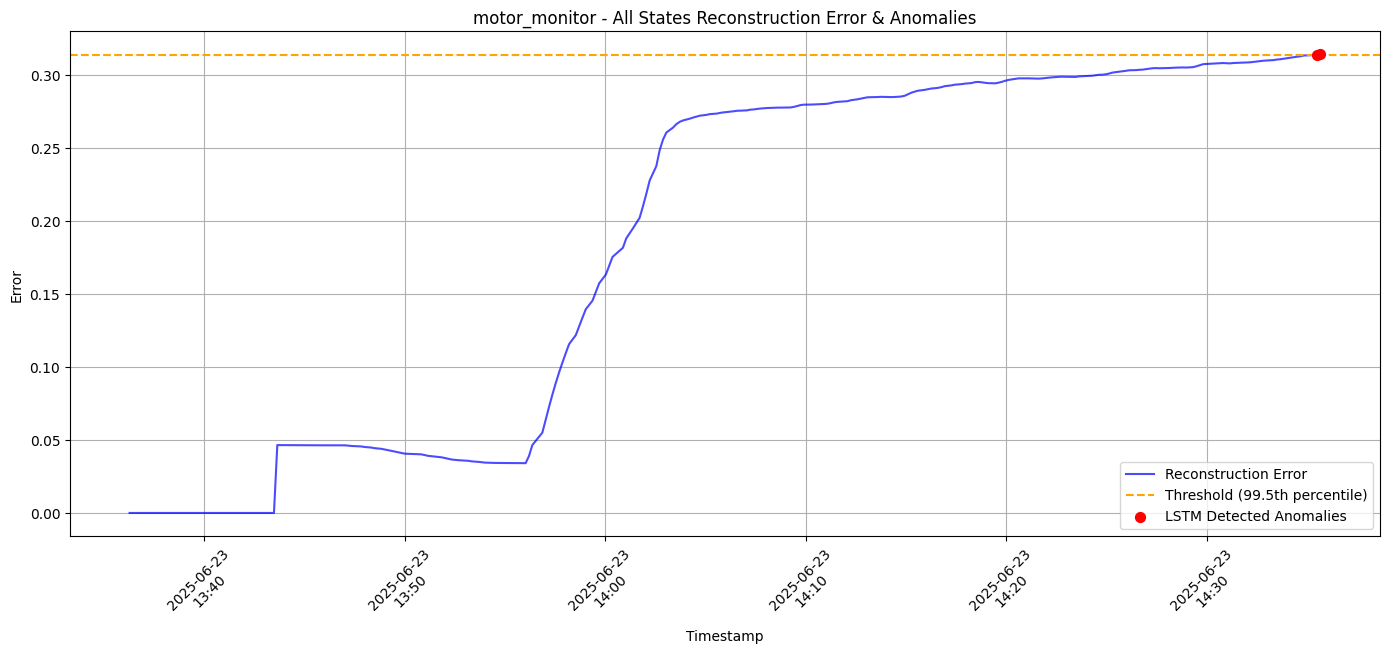

📤 Exported 252 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.22 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313921 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    223
True       1
Name: count, dtype: int64


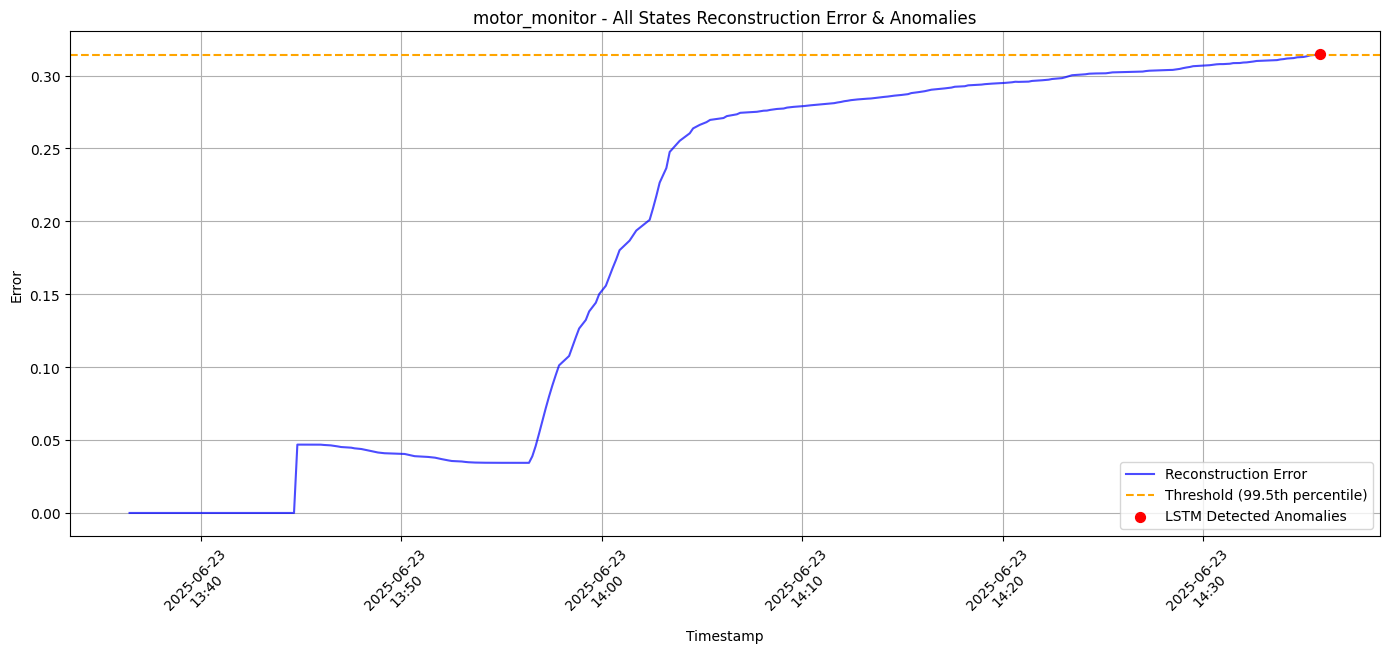

📤 Exported 224 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.38 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310667 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    248
True       2
Name: count, dtype: int64


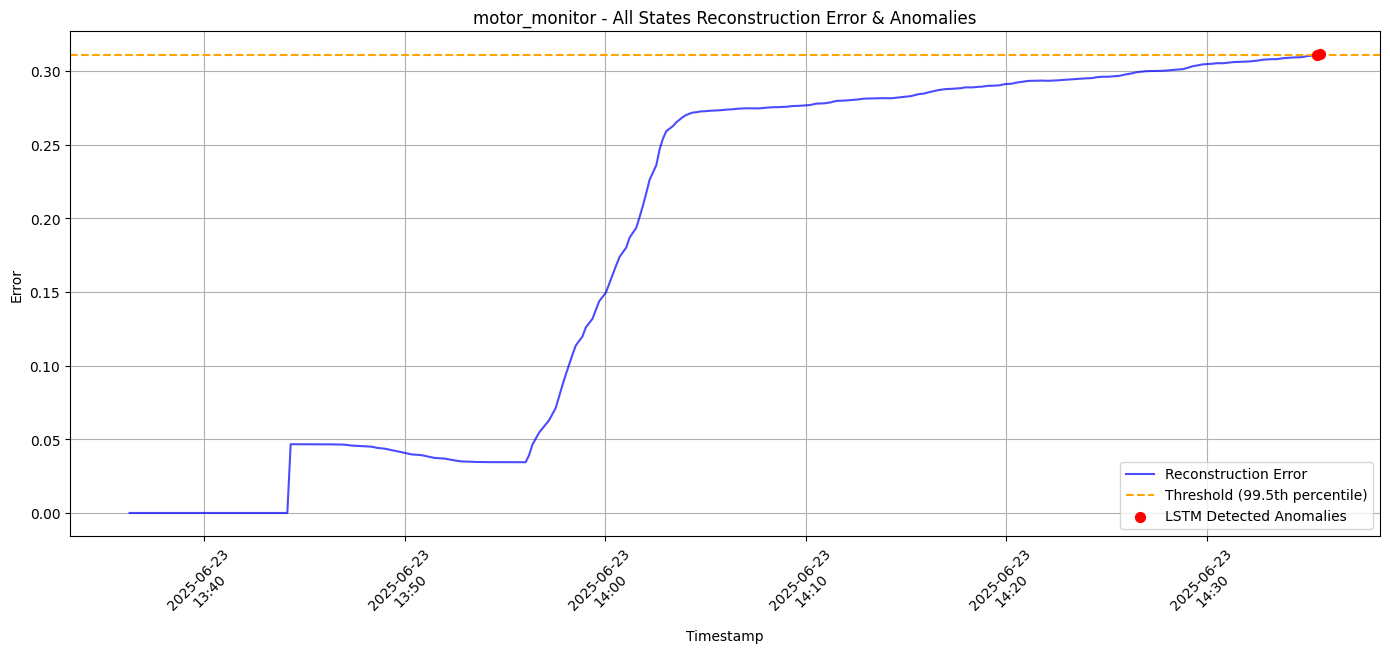

📤 Exported 250 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.36 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312480 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    208
True       1
Name: count, dtype: int64


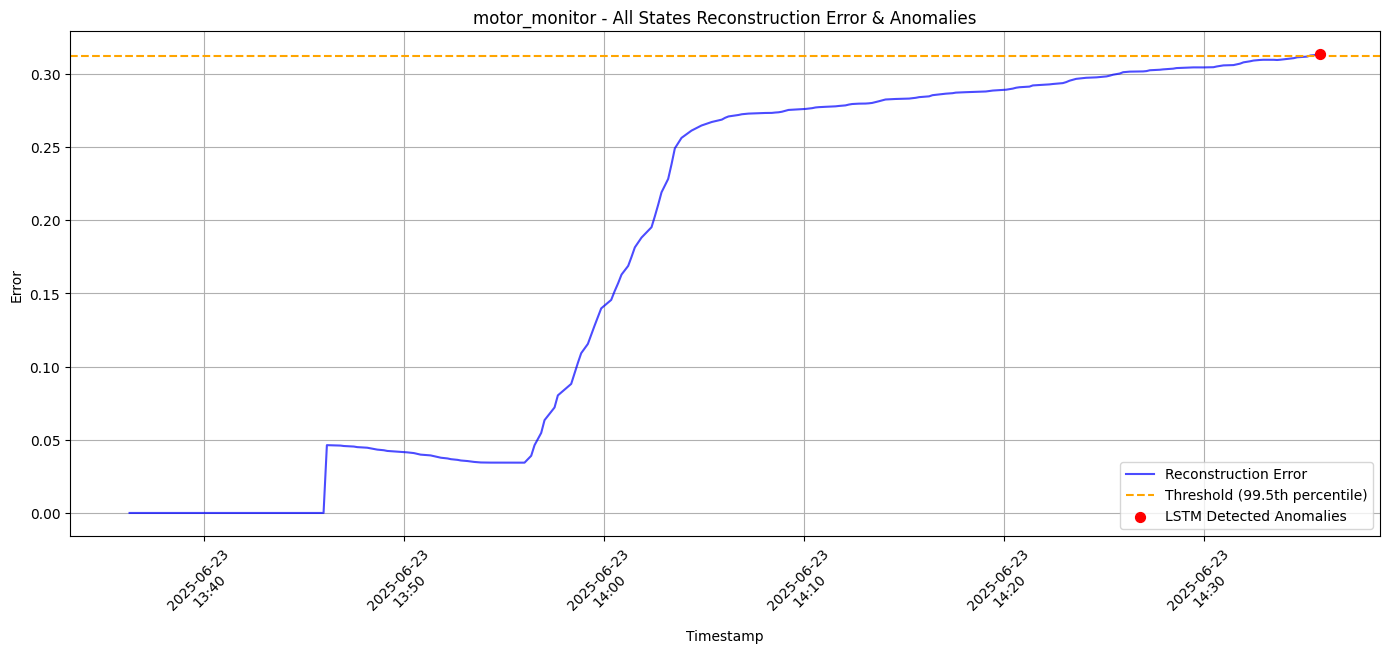

📤 Exported 209 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.29 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316897 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    261
True       2
Name: count, dtype: int64


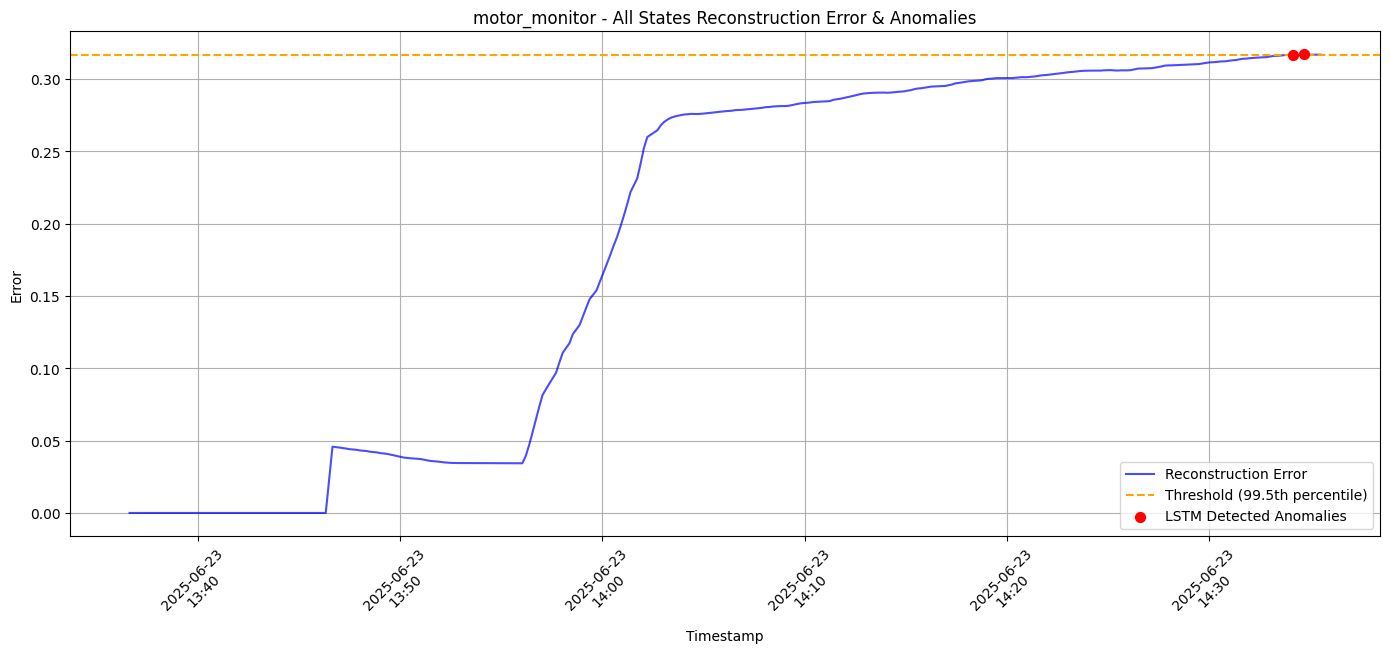

📤 Exported 263 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.87 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312987 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    294
True       2
Name: count, dtype: int64


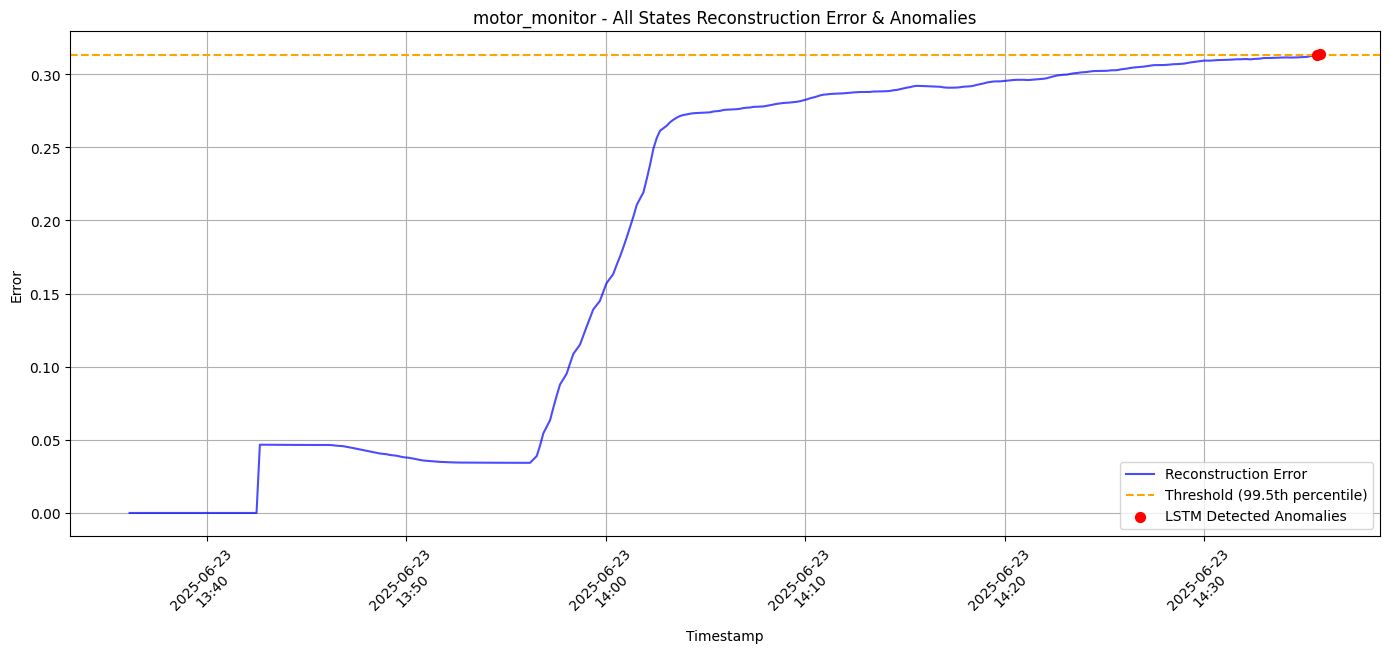

📤 Exported 296 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.50 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.315135 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 2

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    297
True       2
Name: count, dtype: int64


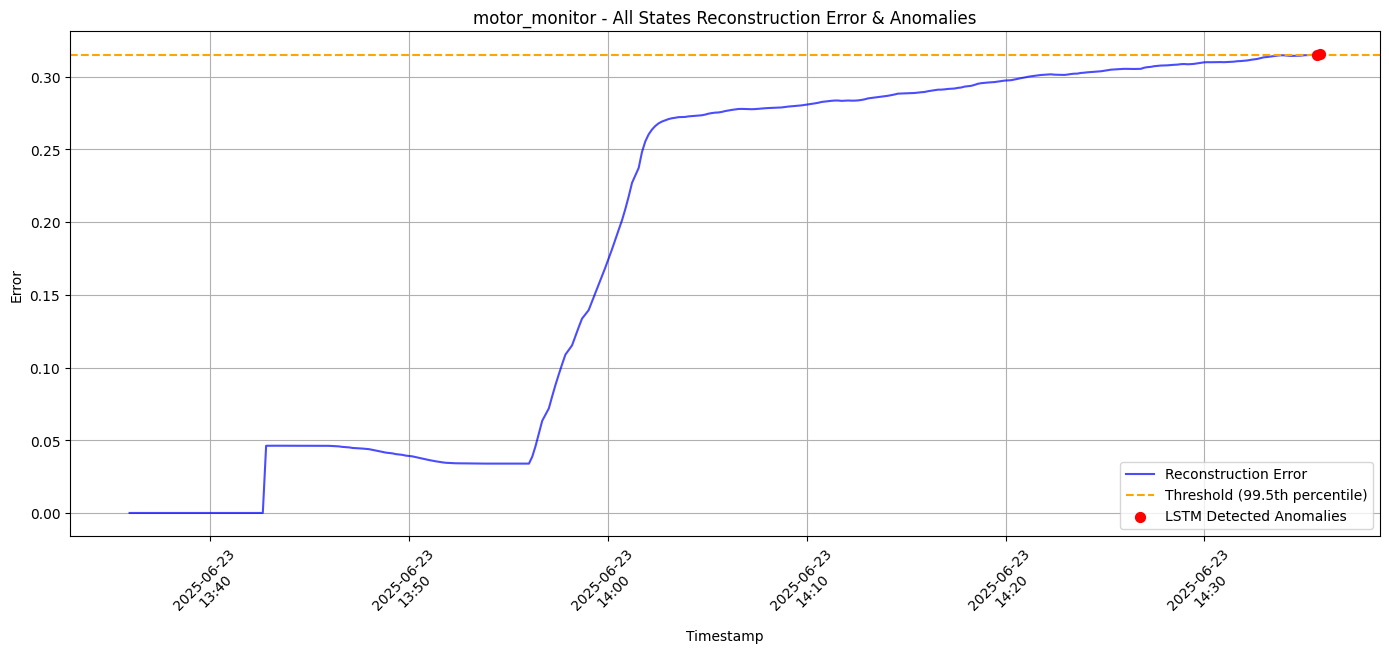

📤 Exported 299 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.51 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312870 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    195
True       1
Name: count, dtype: int64


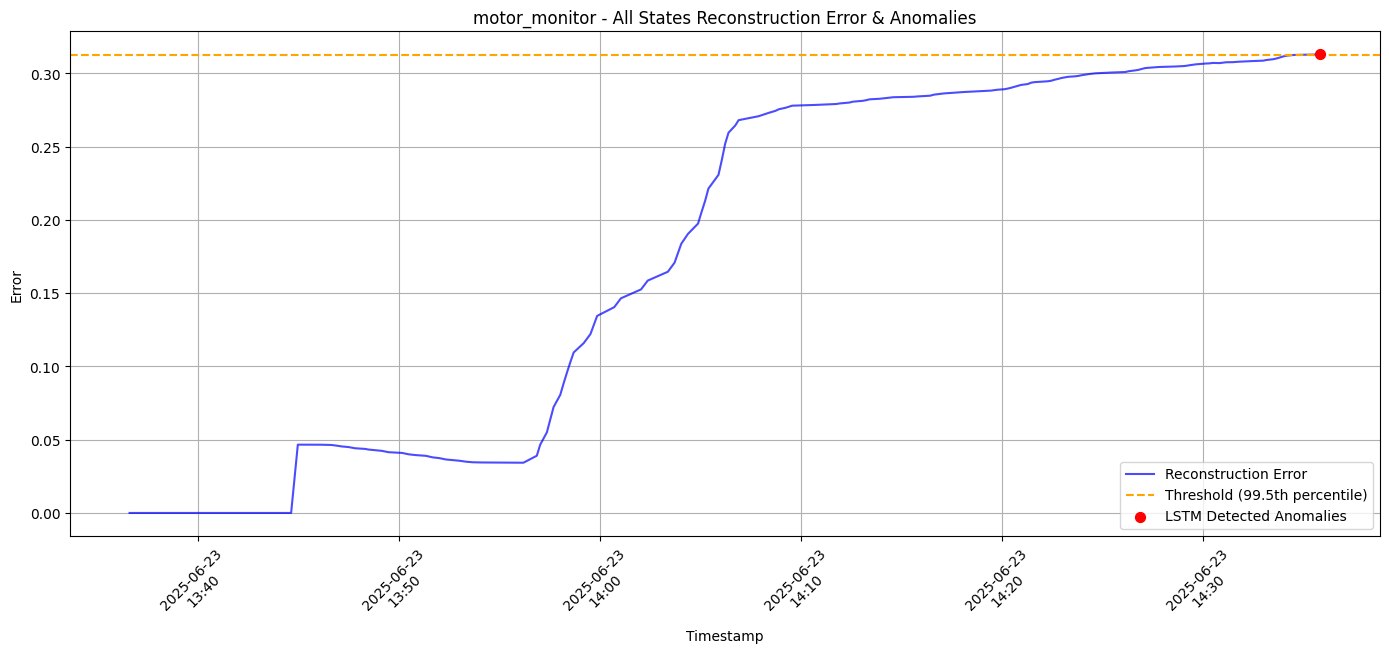

📤 Exported 196 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.46 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313008 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    210
True       1
Name: count, dtype: int64


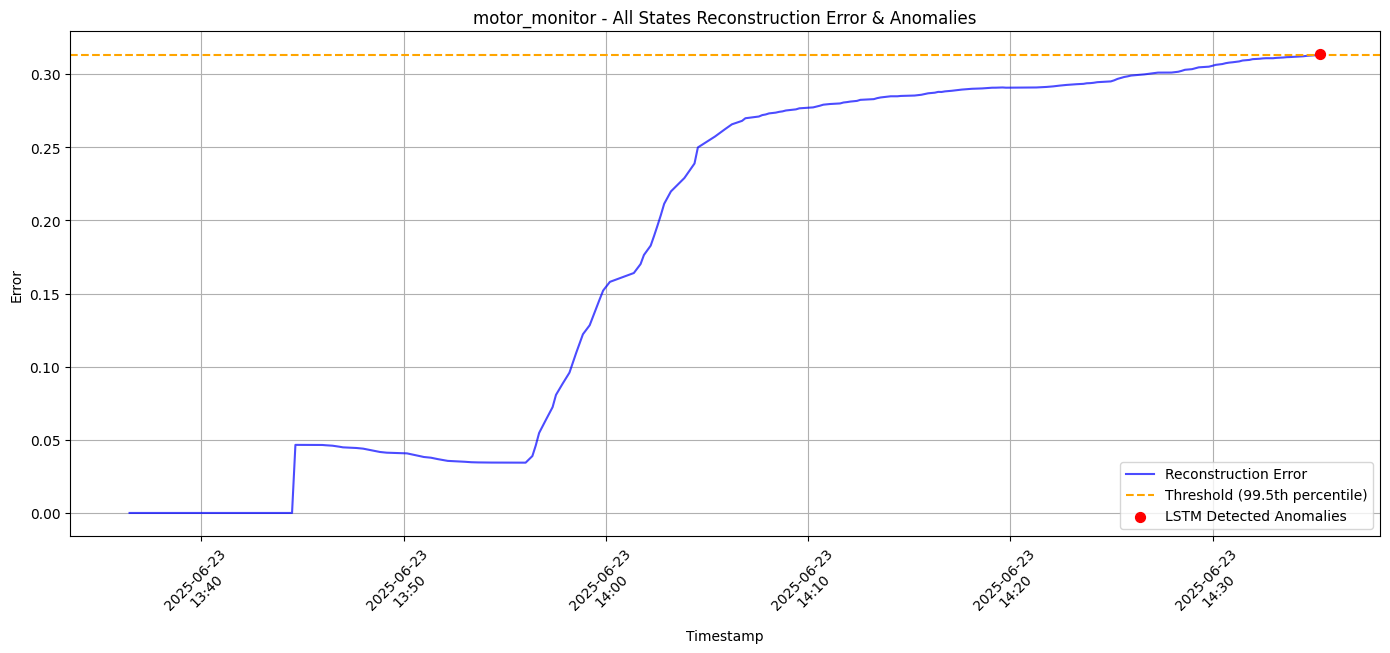

📤 Exported 211 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.26 sec

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.317930 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 1

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    222
True       1
Name: count, dtype: int64


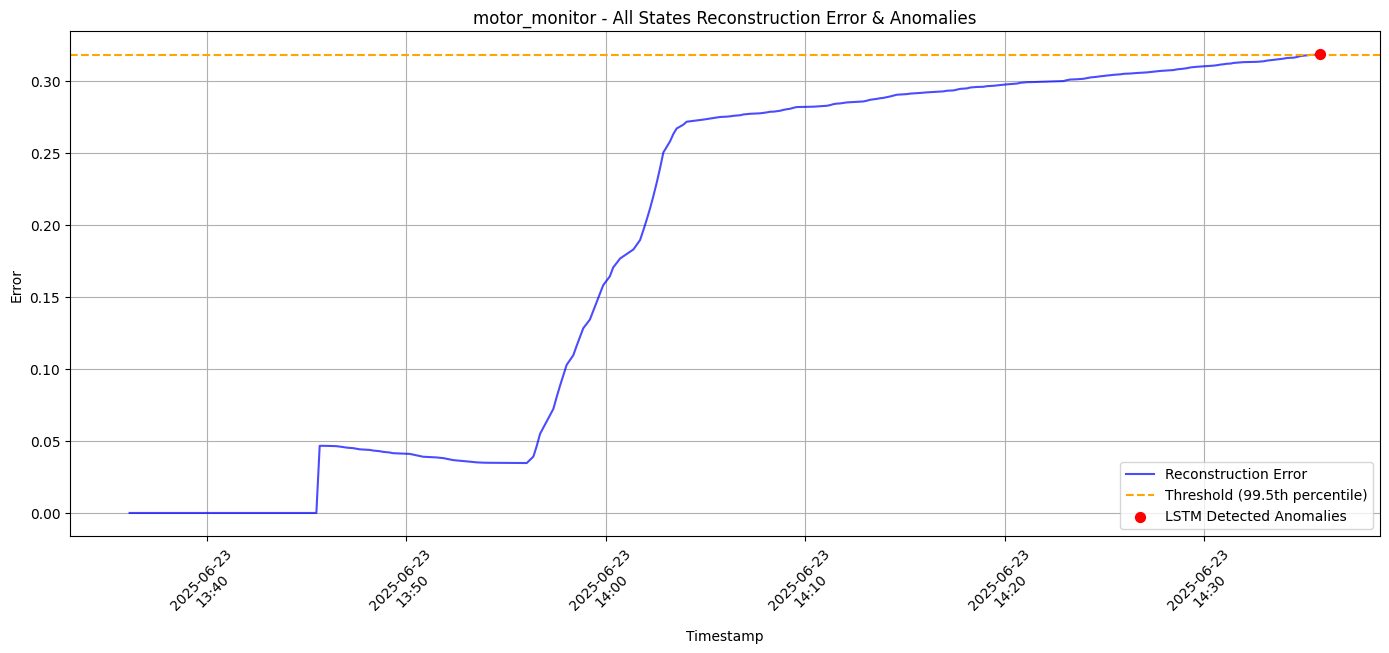

📤 Exported 223 records for motor_monitor to JSON
✅ Finished motor_monitor in 2.55 sec


In [3]:
# --- Main execution flow ---
mode = "query"  # Change to "csv" for CSV processing, "query" for database query

if mode == "csv":
    device_files = get_device_files()
    all_results = {}

    for device_type, csv_file_path in device_files: # get_device_files now returns full_path
        result = process_device(device_type, csv_file_path)
        if result is not None:
            all_results[device_type] = result

    # Removed RF training loop as RF classifier is being removed from AD repo
    # for device_name, df_result in all_results.items():
    #     train_rf_for_device(device_name, df_result)

    import time # Re-import time if needed for global_end_time

    global_end_time = time.time()

    end_memory = process.memory_info().rss / (1024 * 1024)

    print("\n✅ ALL DEVICES PROCESSED")
    print(f"⏱️ Total Time: {global_end_time - global_start_time:.2f} sec")
    print(f"💾 Start Memory: {start_memory:.2f} MB")
    print(f"💾 End Memory: {end_memory:.2f} MB")
    print(f"📈 Memory Growth: {end_memory - start_memory:.2f} MB")

elif mode == "query":
    conn = pg_conn.get_postgres_connection()

    motor_list = pg_conn.get_all_motor_names(conn)

    results = {}

    for motor_name in motor_list:
        result = process_device_query("motor_monitor", pg_conn.get_motor_timeseries(conn, motor_name))

    conn.close()
